In [3]:
import os
os.environ["OMP_NUM_THREADS"] = "8"        # export OMP_NUM_THREADS=4
os.environ["OPENBLAS_NUM_THREADS"] = "8"   # export OPENBLAS_NUM_THREADS=4 
os.environ["MKL_NUM_THREADS"] = "8"        # export MKL_NUM_THREADS=6
os.environ["VECLIB_MAXIMUM_THREADS"] = "8" # export VECLIB_MAXIMUM_THREADS=478
os.environ["NUMEXPR_NUM_THREADS"] = "8"

## Imports

In [5]:
import io
import os
import gzip
import json
import scipy
import random
import warnings
import numpy as np
import numba as nb
import pandas as pd
import datetime as dt
import seaborn as sns
from tqdm import tqdm
import scipy.stats as st
from collections import OrderedDict
import scipy.sparse as sparse
from scipy.linalg import orth
import matplotlib.pyplot as plt
from numpy import linalg as lin
import implicit
import pickle
warnings.filterwarnings('ignore')
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import svds
from datetime import datetime as dt_dt
from scipy.sparse.linalg import spsolve
from numpy.linalg import qr as QR_decomp
from scipy.sparse import csr_matrix, find
from pandas.api.types import CategoricalDtype
from typing import List
import torch
import torch.nn.functional as F
from torch import nn
from polara.evaluation.pipelines import random_grid
import bottleneck as bn

## Functions

In [6]:
import sys
sys.path.append('/home/oolaleke/incremental_PSI/Scripts/')
#sys.path.append('/content/')

In [7]:
import a_DataHelpers
import b_AlgoFunctions
import c_PredEval
import d_CorrScores
import e_VAEfunction

In [8]:
from a_DataHelpers import getPivotMonths,Time_DataSplit,TestTrain_DataSplit,SingleRatingMatrix
from a_DataHelpers import AllRatingMatrices,All_SingleStepRatMat,psiStep_RatMat,psiAllStep_RatMat
from a_DataHelpers import Find_NewUsersItems,adjustedPSI_DF,adjustedAllDF,get_NEWHoldout,ADJUST_mainDF
from a_DataHelpers import  SingleStepRatMat_2,AllSingleStepRatMat_2

from b_AlgoFunctions import integrator,getStartingValues,integratorOnMat,last_psiTrainMat, pureSVD
from b_AlgoFunctions import Updt_RowMatrix,getRow_Mat,row_update, Updt_ColMatrix,getCol_Mat,colunm_update
from b_AlgoFunctions import UsersItems_RatPair,getRowCol_psiupdt,ITEMS_defferredStatus,USERS_defferredStatus
from b_AlgoFunctions import getV_listUpdate, SingleStep_UPDATE,ALLSTEPs_UPDATE, auc_score,TrainTest
from b_AlgoFunctions import mean_auc,tune_ALS,nonzeros,least_squares_cg,alternating_least_squares_cg

from c_PredEval import TopNPred,TQDMgetALLTopNPred, Hitrate_Eval,getAll_HitRate,mean_confidence_interval
from c_PredEval import TQDMgetALLTopNPred_ALLUSERS,getALLTopNPred_ALLUSERS,get_ALLRandPred
from c_PredEval import topN_Index,getAll_RandomHitRate,getMOSTPOP_Pred,getAll_MostPOPHitRate,getAll_MOSTPOP_Pred
from c_PredEval import StepCoverage_Ratio,AllSteps_Coverage_Ratio,getAll_VAEMRR, MRR_Eval,getAll_MRR_Eval
from c_PredEval import TQDMgetAll_MRR_Eval, getAll_MostPOP_MRR,getAll_RandomRecMRR, ials_TopNPred,ials_getALLPred
from c_PredEval import ials_getALLPredTQDM,ials_ALLUSERSpred,ialsALLPred_ALLUSERS,TQDM_ialsALLPred_ALLUSERS

from d_CorrScores import no_copy_csr_matrix,build_rank_weights_matrix,rank_weighted_jaccard_index
from d_CorrScores import Updt_getAll_AvgCorr, updtCorr_4AllRanks

from e_VAEfunction import split_users, split_train_test, numerize_data, get_TrainRatMat, getTrainTest_RatMat


In [68]:
def SingleStepRatMat_2(DF,V,user_column,item_column):  ##rows_ = n_users,cols_ = n_items
    rows_ = DF[user_column].max()+1 
    cols_ = V.shape[0] 
    
    rows0 = DF[user_column].values
    cols0 = DF[item_column].values
    data  = np.broadcast_to(1., DF.shape[0]) # ignore ratings

    A0_Rating_matrix = coo_matrix((data, (rows0, cols0)), shape=(rows_, cols_)).tocsr()
    if A0_Rating_matrix.nnz < len(data):
        A0_Rating_matrix = A0_Rating_matrix._with_data(np.broadcast_to(1., A0_Rating_matrix.nnz), copy=False)

    return A0_Rating_matrix

def AllSingleStepRatMat_2(DFList,Vlist,user_column,item_column):
    Rating_matrix_list = []
    for df,v in zip(DFList,Vlist):
        df_Mat = SingleStepRatMat_2(df,v,user_column,item_column)
        Rating_matrix_list.append(df_Mat)
    return Rating_matrix_list              


## Apply Functions on *MovieLenDF*

###Import Clean Data 

In [30]:
ML1M_DF = pd.read_csv('/mnt/bulky/oolaleke/TDM_Dataset/ML_1M/newIncreMLDF_1M.zip') 
ML1M_DF['timestamp'] = pd.to_datetime(ML1M_DF['timestamp']) 
print(ML1M_DF.shape)   #userId_int
print(ML1M_DF.dtypes)
ML1M_DF

(575281, 7)
userId_int               int64
movieId_int              int64
rating                   int64
timestamp       datetime64[ns]
userId                   int64
productId                int64
timestamp_YM            object
dtype: object


,userId_int,movieId_int,rating,timestamp,userId,productId,timestamp_YM
0,6040,858,1,2000-04-25 23:05:32,0,0,2000-04
1,6040,2384,1,2000-04-25 23:05:54,0,1,2000-04
2,6040,593,1,2000-04-25 23:05:54,0,2,2000-04
3,6040,1961,1,2000-04-25 23:06:17,0,3,2000-04
4,6040,2019,1,2000-04-25 23:06:17,0,4,2000-04
...,...,...,...,...,...,...,...
575276,4958,2453,1,2003-02-28 17:44:20,1081,1838,2003-02
575277,4958,3489,1,2003-02-28 17:45:20,1081,632,2003-02
575278,4958,1407,1,2003-02-28 17:47:23,1081,677,2003-02
575279,4958,3264,1,2003-02-28 17:49:08,1081,1018,2003-02


In [31]:
print(ML1M_DF.shape)
print("For users: ")
print(ML1M_DF['userId'].nunique())
print(ML1M_DF['userId'].max())
print()
print("For items: ")
print(ML1M_DF['productId'].nunique())
print(ML1M_DF['productId'].max())
print()
print("Timestamp")
print(ML1M_DF['timestamp'].min())
print(ML1M_DF['timestamp'].max())

(575281, 7)
For users: 
6038
6037

For items: 
3533
3532

Timestamp
2000-04-25 23:05:32
2003-02-28 17:49:50


### Data Split

In [32]:
print("Size of Dataset: ", ML1M_DF.shape)
print('Min Date: ', ML1M_DF['timestamp'].min())
print("Max Date: ",ML1M_DF['timestamp'].max())

Size of Dataset:  (575281, 7)
Min Date:  2000-04-25 23:05:32
Max Date:  2003-02-28 17:49:50


In [33]:
train_df = ML1M_DF[ML1M_DF['timestamp_YM'] < '2000-12']    #'2016-02
print("DF Shape: ",train_df['userId'].shape)  ##63%
print("NUsers  : ",train_df['userId'].nunique())

DF Shape:  (458067,)
NUsers  :  5361


In [34]:
remainder_df = ML1M_DF[ML1M_DF['timestamp_YM'] >= '2000-12']  
print(remainder_df['userId'].nunique())
print(remainder_df.shape)

1801
(117214, 7)


In [35]:
n = 8500  #num_of_interaction/no_steps
all_df = []
for g, df in remainder_df.groupby(np.arange(len(remainder_df)) // n):
    all_df.append(df)
    print(df['userId'].nunique())
print()
print(g+1)    

213
197
148
194
233
255
286
309
468
526
517
470
453
362

14


###Traintest Split

In [36]:
A0_df = train_df  
print("Initial Training Data: ") 
print("Start Time: ",A0_df['timestamp'].min())
print("End Time:   ",A0_df['timestamp'].max())
print()
print("Num of interactions: ",A0_df.shape[0])
print("Num of uniqueUsers:  ",A0_df['userId'].nunique())

Initial Training Data: 
Start Time:  2000-04-25 23:05:32
End Time:    2000-11-30 23:59:47

Num of interactions:  458067
Num of uniqueUsers:   5361


In [37]:
ΔA_train = all_df[:4] 
print("Incremental Train steps: ",len(ΔA_train))
print("Start Time: ",ΔA_train[0]['timestamp'].min())
print("End Time:   ",ΔA_train[-1]['timestamp'].max())



Incremental Train steps:  4
Start Time:  2000-12-01 00:00:15
End Time:    2000-12-10 04:09:37


In [38]:
ΔA_test = all_df[4:] 
print("Incremental Test steps: ",len(ΔA_test))
print("Start Time: ",ΔA_test[0]['timestamp'].min())
print("End Time:   ",ΔA_test[-1]['timestamp'].max())

Incremental Test steps:  10
Start Time:  2000-12-10 04:09:37
End Time:    2003-02-28 17:49:50


In [39]:
ΔA_test[0]['timestamp'].max()

Timestamp('2000-12-14 00:34:30')

In [40]:
AllDF_list, PSITest_list, HOLDOUT_list,UserItemDF_list = TestTrain_DataSplit(ML1M_DF,'userId','timestamp',ΔA_test)
print(AllDF_list[1]['timestamp'].min())
print(AllDF_list[1]['timestamp'].max())
print()
print(ΔA_test[1]['timestamp'].min())
print(ΔA_test[1]['timestamp'].max())

2000-04-25 23:05:32
2000-12-19 13:44:29

2000-12-14 00:36:17
2000-12-19 13:44:29


In [41]:
for i in range(10):
    print(AllDF_list[i]['userId'].max(),AllDF_list[i]['userId'].nunique())

5787 5788
5869 5870
5973 5974
6029 6030
6029 6030
6030 6031
6032 6033
6034 6035
6035 6036
6037 6038


In [42]:
print(ΔA_test[2].shape)
print(PSITest_list[2].shape)
print(HOLDOUT_list[2]['userId'].nunique())

(8500, 7)
(8214, 7)
286


### Find new users and items

In [43]:
Tstps = ML1M_DF['timestamp']
tr_ts = ΔA_train[-1]['timestamp'].max()
print("ΔA_train_last max date: ",tr_ts)
AllDF_start = ML1M_DF.loc[Tstps <= tr_ts] 
print(AllDF_start['timestamp'].min())
print(AllDF_start['timestamp'].max())
print()
print(AllDF_list[0]['timestamp'].min())
print(AllDF_list[0]['timestamp'].max())

ΔA_train_last max date:  2000-12-10 04:09:37
2000-04-25 23:05:32
2000-12-10 04:09:37

2000-04-25 23:05:32
2000-12-14 00:34:30


In [44]:
New_usersList,New_itemsList = Find_NewUsersItems(AllDF_start,AllDF_list,'userId','productId',N_steps=10)
print(New_usersList[0][:10]) #
print()
print(New_itemsList[0][:10]) #

[5711 5712 5713 5714 5715 5716 5717 5718 5719 5720]

[3478 3479 3480 3481 3482 3483]


In [45]:
print("users,Items")
for i,j in zip(New_usersList,New_itemsList):
    print(i.size,j.size)
    print()
    

users,Items
77 6

82 5

104 0

56 6

0 5

1 5

2 7

2 9

1 9

2 3



## Incre Update

###Get Updt RatMat

In [46]:
rows_i = AllDF_start['userId'].nunique()
cols_i = AllDF_start['productId'].nunique()
print(A0_df.shape)
A0_RatMat_updt = SingleRatingMatrix(A0_df,'userId', 'productId',rows_i,cols_i)
A0_RatMat_updt

(458067, 7)


<5711x3478 sparse matrix of type '<class 'numpy.float64'>'
	with 458067 stored elements in Compressed Sparse Row format>

In [47]:
PSI_TrainMat_updt = AllRatingMatrices(ΔA_train,'userId','productId',rows_i ,cols_i)
PSI_TrainMat_updt

[<5711x3478 sparse matrix of type '<class 'numpy.float64'>'
 	with 8500 stored elements in Compressed Sparse Row format>,
 <5711x3478 sparse matrix of type '<class 'numpy.float64'>'
 	with 8500 stored elements in Compressed Sparse Row format>,
 <5711x3478 sparse matrix of type '<class 'numpy.float64'>'
 	with 8500 stored elements in Compressed Sparse Row format>,
 <5711x3478 sparse matrix of type '<class 'numpy.float64'>'
 	with 8500 stored elements in Compressed Sparse Row format>]

### Allsteps Update

In [48]:
# rows_i = AllDF_start['userId'].nunique()
# cols_i = AllDF_start['productId'].nunique()
# print(AllDF_start.shape)
# AllDF_startRatMat = SingleRatingMatrix(AllDF_start,'userId', 'productId',rows_i,cols_i)

# U_start,S_start,V_start = svds(AllDF_startRatMat,k=50)
# V_start = V_start.T
# print()
# print("U_start shape: ",U_start.shape)
# print("S_start shape: ",S_start.shape)
# print("V_start shape: ",V_start.shape)

In [49]:
U_start,S_start,V_start = last_psiTrainMat(A0_RatMat_updt,PSI_TrainMat_updt,k=20)
print()
print("U_start shape: ",U_start.shape)
print("S_start shape: ",S_start.shape)
print("V_start shape: ",V_start.shape)

100%|██████████| 4/4 [00:00<00:00, 165.83it/s]
U_start shape:  (5711, 20)
S_start shape:  (20, 20)
V_start shape:  (3478, 20)



In [50]:
U_list,S_list,V_list = [],[],[]
U_list.append(U_start)
S_list.append(S_start)
V_list.append(V_start)
print(len(U_list),len(V_list))

1 1


In [51]:
DItems_, DUsers_,In_DomainUSERS,In_DomainITEMS,userID_dict,itemID_dict,AllUpdtUSERS_,AllUpdtITEMS_,U_list,S_list,V_list = ALLSTEPs_UPDATE(AllDF_start,AllDF_list,New_itemsList,New_usersList,U_list,
                                       S_list,V_list,'userId','productId',Nsteps=10,k=20,Forced_Orth=False)

100%|██████████| 9/9 [00:01<00:00,  5.67it/s]


### Output Check

In [52]:
print(AllDF_start['productId'].max())
print(AllDF_start['userId'].max())

3477
5710


In [53]:
print(len(In_DomainITEMS[3477+1:]))
print(In_DomainITEMS[3477+1:][:10])
print()
print(len(In_DomainUSERS[5710+1:]))
print(In_DomainUSERS[5710+1:][:10])

55
[3478, 3479, 3480, 3481, 3482, 3483, 3484, 3487, 3485, 3486]

327
[5711, 5712, 5713, 5714, 5715, 5716, 5717, 5718, 5719, 5720]


In [54]:
#deferred items and users
print(len(DItems_))
print(DItems_[:10])
print()
print(len(DUsers_))
print(DUsers_[:10])

0
[]

0
[]


In [55]:
for x in list(itemID_dict)[3477+1:][:100]:
    print ("Id: {}, UpdtId: {} ".format(x,  itemID_dict[x]))   ##id ==key || updtedid == values  ,itemID_dict

Id: 3478, UpdtId: 3478 
Id: 3479, UpdtId: 3479 
Id: 3480, UpdtId: 3480 
Id: 3481, UpdtId: 3481 
Id: 3482, UpdtId: 3482 
Id: 3483, UpdtId: 3483 
Id: 3484, UpdtId: 3484 
Id: 3487, UpdtId: 3485 
Id: 3485, UpdtId: 3486 
Id: 3486, UpdtId: 3487 
Id: 3488, UpdtId: 3488 
Id: 3491, UpdtId: 3489 
Id: 3492, UpdtId: 3490 
Id: 3493, UpdtId: 3491 
Id: 3494, UpdtId: 3492 
Id: 3489, UpdtId: 3493 
Id: 3490, UpdtId: 3494 
Id: 3495, UpdtId: 3495 
Id: 3496, UpdtId: 3496 
Id: 3497, UpdtId: 3497 
Id: 3498, UpdtId: 3498 
Id: 3499, UpdtId: 3499 
Id: 3500, UpdtId: 3500 
Id: 3501, UpdtId: 3501 
Id: 3502, UpdtId: 3502 
Id: 3503, UpdtId: 3503 
Id: 3504, UpdtId: 3504 
Id: 3505, UpdtId: 3505 
Id: 3506, UpdtId: 3506 
Id: 3507, UpdtId: 3507 
Id: 3508, UpdtId: 3508 
Id: 3509, UpdtId: 3509 
Id: 3510, UpdtId: 3510 
Id: 3511, UpdtId: 3511 
Id: 3512, UpdtId: 3512 
Id: 3513, UpdtId: 3513 
Id: 3514, UpdtId: 3514 
Id: 3515, UpdtId: 3515 
Id: 3516, UpdtId: 3516 
Id: 3517, UpdtId: 3517 
Id: 3518, UpdtId: 3518 
Id: 3519, UpdtId

In [56]:
for x in list(userID_dict)[5710:][:100]:
    print ("Id: {}, UpdtId: {} ".format(x,  userID_dict[x]))   ##id ==key || updtedid == values 

Id: 5710, UpdtId: 5710 
Id: 5711, UpdtId: 5711 
Id: 5712, UpdtId: 5712 
Id: 5713, UpdtId: 5713 
Id: 5714, UpdtId: 5714 
Id: 5715, UpdtId: 5715 
Id: 5716, UpdtId: 5716 
Id: 5717, UpdtId: 5717 
Id: 5718, UpdtId: 5718 
Id: 5719, UpdtId: 5719 
Id: 5720, UpdtId: 5720 
Id: 5721, UpdtId: 5721 
Id: 5722, UpdtId: 5722 
Id: 5723, UpdtId: 5723 
Id: 5724, UpdtId: 5724 
Id: 5725, UpdtId: 5725 
Id: 5726, UpdtId: 5726 
Id: 5727, UpdtId: 5727 
Id: 5728, UpdtId: 5728 
Id: 5729, UpdtId: 5729 
Id: 5730, UpdtId: 5730 
Id: 5731, UpdtId: 5731 
Id: 5732, UpdtId: 5732 
Id: 5733, UpdtId: 5733 
Id: 5734, UpdtId: 5734 
Id: 5735, UpdtId: 5735 
Id: 5736, UpdtId: 5736 
Id: 5737, UpdtId: 5737 
Id: 5738, UpdtId: 5738 
Id: 5739, UpdtId: 5739 
Id: 5740, UpdtId: 5740 
Id: 5741, UpdtId: 5741 
Id: 5742, UpdtId: 5742 
Id: 5743, UpdtId: 5743 
Id: 5744, UpdtId: 5744 
Id: 5745, UpdtId: 5745 
Id: 5746, UpdtId: 5746 
Id: 5747, UpdtId: 5747 
Id: 5748, UpdtId: 5748 
Id: 5749, UpdtId: 5749 
Id: 5750, UpdtId: 5750 
Id: 5751, UpdtId

In [57]:
print(len(U_list),len(V_list))
print(U_list[0].shape,V_list[0].shape)
print()
for u,v in zip(U_list[1:],V_list[1:]):
    print(u.shape,v.shape)   

11 11
(5711, 20) (3478, 20)

(5788, 20) (3484, 20)
(5870, 20) (3489, 20)
(5974, 20) (3489, 20)
(6030, 20) (3495, 20)
(6030, 20) (3500, 20)
(6031, 20) (3505, 20)
(6033, 20) (3512, 20)
(6035, 20) (3521, 20)
(6036, 20) (3530, 20)
(6038, 20) (3533, 20)


In [58]:
for i,j in zip(AllUpdtUSERS_,AllUpdtITEMS_):
    print(len(i),len(j))

5788 3484
5870 3489
5974 3489
6030 3495
6030 3500
6031 3505
6033 3512
6035 3521
6036 3530
6038 3533


In [59]:
print(len(In_DomainUSERS),len(In_DomainITEMS))
print(ML1M_DF['userId'].nunique(),ML1M_DF['productId'].nunique())

6038 3533
6038 3533


Data Adjustments

### Data Adjustment

In [60]:
len(AllUpdtITEMS_)

10

In [61]:
newHOLDOUT_LIST = get_NEWHoldout(HOLDOUT_list,userID_dict,itemID_dict,AllUpdtUSERS_,AllUpdtITEMS_,'userId','productId')
print(len(newHOLDOUT_LIST))
print()
for old,new in zip(HOLDOUT_list,newHOLDOUT_LIST):
    print(old.shape[0],new.shape[0])

10it [00:00, 118.81it/s]10

233 233
255 255
286 286
309 309
468 468
526 526
517 517
470 470
453 453
362 362



In [62]:
newUserItem_list = adjustedAllDF(UserItemDF_list,userID_dict,itemID_dict,AllUpdtUSERS_,AllUpdtITEMS_,'userId','productId')
print()
for df in newUserItem_list:
    print(df['Updated_UserID'].max(),df['Updated_ItemID'].max())

10it [00:06,  1.49it/s]
5787 3483
5869 3488
5973 3488
6029 3494
6029 3498
6030 3504
6032 3509
6034 3520
6035 3529
6037 3531



In [63]:
new_PSIDFlist = adjustedPSI_DF(PSITest_list,userID_dict,itemID_dict,AllUpdtUSERS_,AllUpdtITEMS_,'userId','productId')
for old,new in zip(PSITest_list,new_PSIDFlist):
    print(old.shape[0],new.shape[0])

10it [00:00, 49.88it/s]8267 8267
8245 8245
8214 8214
8191 8191
8032 8032
7974 7974
7983 7983
8030 8030
8047 8047
6352 6352



In [46]:
newMLDF_1M = ADJUST_mainDF(ML1M_DF,userID_dict,itemID_dict,AllUpdtUSERS_,AllUpdtITEMS_,'userId','productId')
print(newMLDF_1M.shape)
print(newMLDF_1M['userId'].max(),newMLDF_1M['productId'].max())
print(newMLDF_1M['userId'].nunique(),newMLDF_1M['productId'].nunique())
print()
print(newMLDF_1M['Updated_UserID'].max(),newMLDF_1M['Updated_ItemID'].max())
print(newMLDF_1M['Updated_UserID'].nunique(),newMLDF_1M['Updated_ItemID'].nunique())
#newAMZB_DF.head()

(575281, 9)
6037 3532
6038 3533

6037 3532
6038 3533


In [ ]:
#Hello2021

In [48]:
with open('MLDF1M_newUserItem.pkl', 'wb') as f:
     pickle.dump(newUserItem_list, f)

with open('MLDF1M_newHoldout.pkl', 'wb') as f:
     pickle.dump(newHOLDOUT_LIST, f)

with open('MLDF1M_newPSITest.pkl', 'wb') as f:
     pickle.dump(new_PSIDFlist, f)     

In [49]:
newMLDF_1M.to_csv('MLDF1M_afterUpdt.csv.zip',index=False,compression='zip')

### Get UserItem MAT

In [50]:
for i in range(10):
    print(newUserItem_list[i]['Updated_UserID'].max(),newUserItem_list[i]['Updated_ItemID'].max())

5787 3483
5869 3488
5973 3488
6029 3494
6029 3498
6030 3504
6032 3509
6034 3520
6035 3529
6037 3531


In [64]:
print(len(U_list[1:]),len(V_list[1:]))
for u,v in zip(U_list[1:],V_list[1:]):
    print(u.shape[0],v.shape[0])   

10 10
5788 3484
5870 3489
5974 3489
6030 3495
6030 3500
6031 3505
6033 3512
6035 3521
6036 3530
6038 3533


In [69]:
#UserItem_Matupdt = All_SingleStepRatMat(newUserItem_list,'Updated_UserID','Updated_ItemID')
UserItem_Matupdt = AllSingleStepRatMat_2(newUserItem_list,V_list[1:],'Updated_UserID','Updated_ItemID')
print(len(UserItem_Matupdt))
UserItem_Matupdt

10


[<5788x3484 sparse matrix of type '<class 'numpy.float64'>'
 	with 500332 stored elements in Compressed Sparse Row format>,
 <5870x3489 sparse matrix of type '<class 'numpy.float64'>'
 	with 508812 stored elements in Compressed Sparse Row format>,
 <5974x3489 sparse matrix of type '<class 'numpy.float64'>'
 	with 517278 stored elements in Compressed Sparse Row format>,
 <6030x3495 sparse matrix of type '<class 'numpy.float64'>'
 	with 525757 stored elements in Compressed Sparse Row format>,
 <6030x3500 sparse matrix of type '<class 'numpy.float64'>'
 	with 534098 stored elements in Compressed Sparse Row format>,
 <6031x3505 sparse matrix of type '<class 'numpy.float64'>'
 	with 542538 stored elements in Compressed Sparse Row format>,
 <6033x3512 sparse matrix of type '<class 'numpy.float64'>'
 	with 551048 stored elements in Compressed Sparse Row format>,
 <6035x3521 sparse matrix of type '<class 'numpy.float64'>'
 	with 559597 stored elements in Compressed Sparse Row format>,
 <6036x3

In [53]:
# print(AllDF_start['userId'].nunique(),AllDF_start['productId'].nunique())
# print()
# for i,j in zip(AllUpdtUSERS_,AllUpdtITEMS_):
#     print(len(i),len(j))

### V_list

In [70]:
print(len(UserItem_Matupdt),len(newHOLDOUT_LIST))

10 10


In [71]:
Vpsi_listUpdt = V_list[1:]
for v in Vpsi_listUpdt:
    print(v.shape)

(3484, 20)
(3489, 20)
(3489, 20)
(3495, 20)
(3500, 20)
(3505, 20)
(3512, 20)
(3521, 20)
(3530, 20)
(3533, 20)


In [72]:
V_1 = Vpsi_listUpdt[0]
V_1.shape

(3484, 20)

### All Prediction

In [73]:
print(UserItem_Matupdt[0].shape)
UserItem_Matupdt[0]

(5788, 3484)


<5788x3484 sparse matrix of type '<class 'numpy.float64'>'
	with 500332 stored elements in Compressed Sparse Row format>

In [74]:
# for i,j,k in zip(UserItem_Matupdt,Vpsi_listUpdt,newUserItem_list):
#     print(i.shape[1],j.shape[0],k['Updated_ItemID'].max())

In [75]:
AllUsers_updtPRED =  TQDMgetALLTopNPred_ALLUSERS(UserItem_Matupdt,Vpsi_listUpdt, N=10) 
print(len(AllUsers_updtPRED))
AllUsers_updtPRED[:2]

10it [00:04,  2.49it/s]10



[array([[ 136,  138,  142, ...,  858,  256,  131],
        [ 140,  563,  398, ...,  412,  134,  365],
        [  62,  413,   59, ...,  695,   50,  219],
        ...,
        [  59,   57,  566, ...,  156,  576,  184],
        [ 271,  413,  156, ...,  254,  818, 1238],
        [  87,  223,  292, ...,  848,  262,  461]]),
 array([[136, 138, 142, ..., 858, 256, 131],
        [140, 563, 398, ..., 412, 134, 365],
        [ 62, 413,  59, ..., 695,  50, 219],
        ...,
        [261, 644, 647, ..., 254, 549, 272],
        [138, 137,   0, ..., 317, 136,  89],
        [ 91,  40, 223, ..., 254,  73, 156]])]

In [76]:
AllUsers_updtPRED[-1].shape

(6038, 10)

In [83]:
with open('/mnt/bulky/oolaleke/TDM_Dataset/ML_1M/MLDF1M_UpdtPSI_allPRED.pkl', 'wb') as f:
     pickle.dump(AllUsers_updtPRED, f)


In [ ]:
# with open('/mnt/bulky/oolaleke/TDM_Dataset/AMZB_UpdtPSI_AllPRED.pkl', 'rb') as f:
#      allpred_updt = pickle.load(f)
# print(len(allpred_updt))
# allpred_updt[:2]

In [ ]:
# ##lOAD Saved Lists...
# with open('/mnt/bulky/oolaleke/TDM_Dataset/AMZB_newUserItem.pkl', 'rb') as f:
#      newUserItem_LIST = pickle.load(f)

# with open('/mnt/bulky/oolaleke/TDM_Dataset/AMZB_newPSITest.pkl', 'rb') as f:
#      newPSIDF_LIST = pickle.load(f)


# with open('/mnt/bulky/oolaleke/TDM_Dataset/AMZB_newHoldout.pkl', 'rb') as f:
#      newHOLDOUTDF_LIST = pickle.load(f)

# #newAMZB_DF = pd.read_csv()

## Regular PSI 

### Get Rating Matrices

In [84]:
print(newMLDF_1M.shape)
print(newMLDF_1M['userId'].max(),newMLDF_1M['productId'].max())
print(newMLDF_1M['userId'].nunique(),newMLDF_1M['productId'].nunique())
print()
print(newMLDF_1M['Updated_UserID'].max(),newMLDF_1M['Updated_ItemID'].max())
print(newMLDF_1M['Updated_UserID'].nunique(),newMLDF_1M['Updated_ItemID'].nunique())
newMLDF_1M.head()

(575281, 9)
6037 3532
6038 3533

6037 3532
6038 3533


,userId_int,movieId_int,rating,timestamp,userId,productId,timestamp_YM,Updated_UserID,Updated_ItemID
0,6040,858,1,2000-04-25 23:05:32,0,0,2000-04,0,0
1,6040,2384,1,2000-04-25 23:05:54,0,1,2000-04,0,1
2,6040,593,1,2000-04-25 23:05:54,0,2,2000-04,0,2
3,6040,1961,1,2000-04-25 23:06:17,0,3,2000-04,0,3
4,6040,2019,1,2000-04-25 23:06:17,0,4,2000-04,0,4


In [85]:
rows_i = newMLDF_1M['Updated_UserID'].nunique()
cols_i = newMLDF_1M['Updated_ItemID'].nunique()
print(A0_df.shape)
A0_Rating_matrix = SingleRatingMatrix(A0_df,'userId', 'productId',rows_i,cols_i)  ##changes start within steps...
A0_Rating_matrix

(458067, 7)


<6038x3533 sparse matrix of type '<class 'numpy.float64'>'
	with 458067 stored elements in Compressed Sparse Row format>

In [86]:
for df in new_PSIDFlist:
    print(df['Updated_UserID'].max(),df['Updated_ItemID'].max())

5787 3483
5869 3488
5973 3441
6029 3494
6029 3498
6030 3504
6032 3509
6034 3520
6035 3529
6037 3531


In [87]:
print("Length of PSI_Train :",len(ΔA_train))
print("Length of PSI_Test  :",len(new_PSIDFlist))

Length of PSI_Train : 4
Length of PSI_Test  : 10


In [88]:
PSI_train_matrix = AllRatingMatrices(ΔA_train,'userId','productId',rows_i ,cols_i)
PSI_train_matrix   

[<6038x3533 sparse matrix of type '<class 'numpy.float64'>'
 	with 8500 stored elements in Compressed Sparse Row format>,
 <6038x3533 sparse matrix of type '<class 'numpy.float64'>'
 	with 8500 stored elements in Compressed Sparse Row format>,
 <6038x3533 sparse matrix of type '<class 'numpy.float64'>'
 	with 8500 stored elements in Compressed Sparse Row format>,
 <6038x3533 sparse matrix of type '<class 'numpy.float64'>'
 	with 8500 stored elements in Compressed Sparse Row format>]

In [89]:
PSI_test_matrix = AllRatingMatrices(new_PSIDFlist,'Updated_UserID','Updated_ItemID',rows_i ,cols_i)                                                                      
print(len(PSI_test_matrix))
PSI_test_matrix

10


[<6038x3533 sparse matrix of type '<class 'numpy.float64'>'
 	with 8267 stored elements in Compressed Sparse Row format>,
 <6038x3533 sparse matrix of type '<class 'numpy.float64'>'
 	with 8245 stored elements in Compressed Sparse Row format>,
 <6038x3533 sparse matrix of type '<class 'numpy.float64'>'
 	with 8214 stored elements in Compressed Sparse Row format>,
 <6038x3533 sparse matrix of type '<class 'numpy.float64'>'
 	with 8191 stored elements in Compressed Sparse Row format>,
 <6038x3533 sparse matrix of type '<class 'numpy.float64'>'
 	with 8032 stored elements in Compressed Sparse Row format>,
 <6038x3533 sparse matrix of type '<class 'numpy.float64'>'
 	with 7974 stored elements in Compressed Sparse Row format>,
 <6038x3533 sparse matrix of type '<class 'numpy.float64'>'
 	with 7983 stored elements in Compressed Sparse Row format>,
 <6038x3533 sparse matrix of type '<class 'numpy.float64'>'
 	with 8030 stored elements in Compressed Sparse Row format>,
 <6038x3533 sparse matri

In [90]:
UserItemMAT_regPSI = AllRatingMatrices(newUserItem_list,'Updated_UserID','Updated_ItemID',rows_i ,cols_i) 
UserItemMAT_regPSI  

[<6038x3533 sparse matrix of type '<class 'numpy.float64'>'
 	with 500332 stored elements in Compressed Sparse Row format>,
 <6038x3533 sparse matrix of type '<class 'numpy.float64'>'
 	with 508812 stored elements in Compressed Sparse Row format>,
 <6038x3533 sparse matrix of type '<class 'numpy.float64'>'
 	with 517278 stored elements in Compressed Sparse Row format>,
 <6038x3533 sparse matrix of type '<class 'numpy.float64'>'
 	with 525757 stored elements in Compressed Sparse Row format>,
 <6038x3533 sparse matrix of type '<class 'numpy.float64'>'
 	with 534098 stored elements in Compressed Sparse Row format>,
 <6038x3533 sparse matrix of type '<class 'numpy.float64'>'
 	with 542538 stored elements in Compressed Sparse Row format>,
 <6038x3533 sparse matrix of type '<class 'numpy.float64'>'
 	with 551048 stored elements in Compressed Sparse Row format>,
 <6038x3533 sparse matrix of type '<class 'numpy.float64'>'
 	with 559597 stored elements in Compressed Sparse Row format>,
 <6038x3

In [ ]:
# print(AllDF_list[-1]['userId'].nunique(),AllDF_list[-1]['productId'].nunique())
# print(AMZB_DF['userId'].nunique(),AMZB_DF['productId'].nunique())

22799 8620
22799 8620


In [92]:
Vpsi_listReg =  integratorOnMat(A0_Rating_matrix,PSI_train_matrix,PSI_test_matrix,k=20)  #PSI
print(len(Vpsi_listReg))  

10


In [93]:
Vpsi_listReg[0].shape

(3533, 20)

### All Pred

In [94]:
AllUsersRegPIS_PRED =  TQDMgetALLTopNPred_ALLUSERS(UserItemMAT_regPSI,Vpsi_listReg, N=10) 
print(len(AllUsersRegPIS_PRED))
AllUsersRegPIS_PRED[:2]

10it [00:04,  2.29it/s]10



[array([[ 136,  138,  142, ...,  858,  256,  131],
        [ 140,  563,  398, ...,  412,  134,  365],
        [  62,  413,   59, ...,  695,   50,  219],
        ...,
        [1181, 1179, 1182, ..., 1177, 1176, 3532],
        [1181, 1179, 1182, ..., 1177, 1176, 3532],
        [1181, 1179, 1182, ..., 1177, 1176, 3532]]),
 array([[ 136,  138,  142, ...,  858,  256,  131],
        [ 140,  563,  398, ...,  412,  134,  365],
        [  62,   59,  413, ...,  695,   50,  219],
        ...,
        [1181, 1179, 1182, ..., 1177, 1176, 3532],
        [1181, 1179, 1182, ..., 1177, 1176, 3532],
        [1181, 1179, 1182, ..., 1177, 1176, 3532]])]

In [95]:
with open('/mnt/bulky/oolaleke/TDM_Dataset/ML_1M/MLDF1M_PSI_allPRED.pkl', 'wb') as f:
     pickle.dump(AllUsersRegPIS_PRED, f)


In [96]:
AllUsersRegPIS_PRED[2].shape

(6038, 10)

## Pure SVD

### Get Rating Matrices

In [9]:
#MOVIElen_1M
newMLDF_1M = pd.read_csv('/mnt/bulky/oolaleke/TDM_Dataset/ML_1M/MLDF1M_afterUpdt.csv.zip')
newMLDF_1M['timestamp'] = pd.to_datetime(newMLDF_1M['timestamp']) 
print(newMLDF_1M.shape)   #userId_int
newMLDF_1M.head()

(575281, 9)


,userId_int,movieId_int,rating,timestamp,userId,productId,timestamp_YM,Updated_UserID,Updated_ItemID
0,6040,858,1,2000-04-25 23:05:32,0,0,2000-04,0,0
1,6040,2384,1,2000-04-25 23:05:54,0,1,2000-04,0,1
2,6040,593,1,2000-04-25 23:05:54,0,2,2000-04,0,2
3,6040,1961,1,2000-04-25 23:06:17,0,3,2000-04,0,3
4,6040,2019,1,2000-04-25 23:06:17,0,4,2000-04,0,4


In [10]:
import pickle

with open('/mnt/bulky/oolaleke/TDM_Dataset/ML_1M/MLDF1M_newHoldout.pkl', 'rb') as f:
     newHoldout_list = pickle.load(f)     
    
with open('/mnt/bulky/oolaleke/TDM_Dataset/ML_1M/MLDF1M_newUserItem.pkl', 'rb') as f:
     newUserItem_list = pickle.load(f)


In [11]:
rows_i = newMLDF_1M['Updated_UserID'].nunique()
cols_i = newMLDF_1M['Updated_ItemID'].nunique()
SVD_UserItemMAT = AllRatingMatrices(newUserItem_list,'Updated_UserID','Updated_ItemID',rows_i ,cols_i) ##Same as UserItemMAT_regPSI
SVD_UserItemMAT

[<6038x3533 sparse matrix of type '<class 'numpy.float64'>'
 	with 500332 stored elements in Compressed Sparse Row format>,
 <6038x3533 sparse matrix of type '<class 'numpy.float64'>'
 	with 508812 stored elements in Compressed Sparse Row format>,
 <6038x3533 sparse matrix of type '<class 'numpy.float64'>'
 	with 517278 stored elements in Compressed Sparse Row format>,
 <6038x3533 sparse matrix of type '<class 'numpy.float64'>'
 	with 525757 stored elements in Compressed Sparse Row format>,
 <6038x3533 sparse matrix of type '<class 'numpy.float64'>'
 	with 534098 stored elements in Compressed Sparse Row format>,
 <6038x3533 sparse matrix of type '<class 'numpy.float64'>'
 	with 542538 stored elements in Compressed Sparse Row format>,
 <6038x3533 sparse matrix of type '<class 'numpy.float64'>'
 	with 551048 stored elements in Compressed Sparse Row format>,
 <6038x3533 sparse matrix of type '<class 'numpy.float64'>'
 	with 559597 stored elements in Compressed Sparse Row format>,
 <6038x3

In [13]:
##Tuning:
def SVDoptimalSearch(RatingMat,holdout,user_column,item_column,start,end,increment,N=10):
    AllHitrate = []
    for rank in tqdm(range(start,end+1,increment)): 
        Usvd, Ssvd, VTsvd = svds(RatingMat, k=rank)
        Vsvd = VTsvd.T
        top_k = TopNPred(RatingMat,holdout,Vsvd, user_column, N)
        hit_r = Hitrate_Eval(holdout,top_k,user_column,item_column)
        AllHitrate.append(hit_r)
    return AllHitrate

In [23]:
AllHitrate = SVDoptimalSearch(SVD_UserItemMAT[0],newHoldout_list[0],'Updated_UserID','Updated_ItemID',start=10,end=100,increment=10,N=10)

 20%|██        | 2/10 [00:00<00:01,  6.29it/s]Number of hits:  15
Total Num of users:  233
Recommendation HitRate:  0.06437768240343347
Number of hits:  17
Total Num of users:  233
Recommendation HitRate:  0.07296137339055794
 30%|███       | 3/10 [00:00<00:01,  5.14it/s]Number of hits:  12
Total Num of users:  233
Recommendation HitRate:  0.05150214592274678
 40%|████      | 4/10 [00:00<00:01,  4.20it/s]Number of hits:  14
Total Num of users:  233
Recommendation HitRate:  0.060085836909871244
 50%|█████     | 5/10 [00:01<00:01,  3.58it/s]Number of hits:  12
Total Num of users:  233
Recommendation HitRate:  0.05150214592274678
 60%|██████    | 6/10 [00:01<00:01,  3.21it/s]Number of hits:  15
Total Num of users:  233
Recommendation HitRate:  0.06437768240343347
 70%|███████   | 7/10 [00:02<00:01,  2.85it/s]Number of hits:  15
Total Num of users:  233
Recommendation HitRate:  0.06437768240343347
 80%|████████  | 8/10 [00:02<00:00,  2.51it/s]Number of hits:  14
Total Num of users:  233
Re

In [24]:
AllHitrate

[0.06437768240343347,
 0.07296137339055794,
 0.05150214592274678,
 0.060085836909871244,
 0.05150214592274678,
 0.06437768240343347,
 0.06437768240343347,
 0.060085836909871244,
 0.060085836909871244,
 0.05150214592274678]

In [26]:
rank_list = list(range(10,101,10))
rank_list

[10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

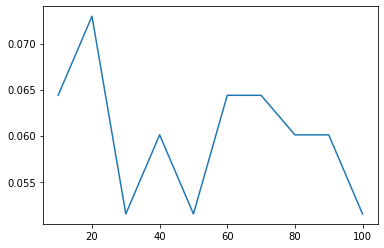

In [27]:
plt.plot(rank_list,AllHitrate)   ###Max == 80

In [97]:
Vsvd_list = pureSVD(SVD_UserItemMAT,k=20)
print(len(Vsvd_list))

10


In [98]:
Vsvd_last = Vsvd_list[-1]
print(Vsvd_last.shape)
Vsvd_last

(3533, 20)


array([[-5.78136534e-02,  1.01859278e-01, -3.09093094e-02, ...,
         4.73060697e-02, -5.63458829e-02,  8.96398052e-02],
       [-6.20111637e-03,  1.75745786e-02,  7.33128684e-03, ...,
        -1.37249409e-02, -1.04115742e-02,  1.42355835e-02],
       [ 1.68719523e-02, -2.55868247e-04, -3.86794689e-02, ...,
        -7.45063256e-02,  1.87714505e-03,  9.78856070e-02],
       ...,
       [-4.11195564e-04, -2.88080722e-04,  3.21895136e-04, ...,
        -2.58801333e-04,  3.95958426e-04,  9.40604543e-05],
       [-2.62450195e-04,  8.68072965e-04,  7.51641417e-04, ...,
        -2.59917487e-04,  3.02481953e-04,  7.40757638e-05],
       [-1.99385601e-21, -1.12561639e-20,  2.67570451e-21, ...,
        -6.68213062e-21,  3.62665612e-21,  7.49341146e-21]])

### SVDAll Pred

In [99]:
AllUsersSVD_PRED =  TQDMgetALLTopNPred_ALLUSERS(SVD_UserItemMAT,Vsvd_list, N=10) 
print(len(AllUsersSVD_PRED))
AllUsersSVD_PRED[:2]

10it [00:04,  2.17it/s]10



[array([[ 136,  138,  142, ...,  858,  256,  319],
        [ 140,  563,  398, ...,  412,  134,  497],
        [  62,   59,  413, ...,   50,  261,  221],
        ...,
        [1181, 1179, 1182, ..., 1177, 1176, 3532],
        [1181, 1179, 1182, ..., 1177, 1176, 3532],
        [1181, 1179, 1182, ..., 1177, 1176, 3532]]),
 array([[ 136,  138,  142, ...,  858,  256,  319],
        [ 140,  563,  398, ...,  412,  134,  497],
        [  62,   59,  413, ...,   50,  695,  221],
        ...,
        [1181, 1179, 1182, ..., 1177, 1176, 3532],
        [1181, 1179, 1182, ..., 1177, 1176, 3532],
        [1181, 1179, 1182, ..., 1177, 1176, 3532]])]

In [100]:
with open('/mnt/bulky/oolaleke/TDM_Dataset/ML_1M/MLDF1M_SVD_allPRED.pkl', 'wb') as f:
     pickle.dump(AllUsersSVD_PRED, f)


## iALS

### ALS_Tuning

In [ ]:
# newAMZB_DF = pd.read_csv("/mnt/bulky/oolaleke/TDM_Dataset/AMZB_afterUpdt.csv")
# print(newAMZB_DF.shape)
# print(newAMZB_DF['userId'].max(),newAMZB_DF['productId'].max())
# print(newAMZB_DF['userId'].nunique(),newAMZB_DF['productId'].nunique())
# print()
# print(newAMZB_DF['Updated_UserID'].max(),newAMZB_DF['Updated_ItemID'].max())
# print(newAMZB_DF['Updated_UserID'].nunique(),newAMZB_DF['Updated_ItemID'].nunique())
# newAMZB_DF.head()

In [83]:
rows_i = newMLDF_1M['Updated_UserID'].nunique()
cols_i = newMLDF_1M['Updated_ItemID'].nunique()
Rating_matrix = SingleRatingMatrix(newUserItem_list[0],'Updated_UserID','Updated_ItemID',rows_i,cols_i)  #changes start within steps...
Rating_matrix

<6038x3533 sparse matrix of type '<class 'numpy.float64'>'
	with 500332 stored elements in Compressed Sparse Row format>

In [84]:
als_params = dict(alpha = [ 0.001,0.05, 0.1, 0.5, 1, 5, 10, 50, 100],
                  regularization = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 10],
                  rank = list(range(10, 81, 10)),
                  iter_array = [10,15,20,25,30])

als_param_grid, als_param_names = random_grid(als_params, n=30)
print(als_param_names)
len(als_param_grid)                 

('alpha', 'regularization', 'rank', 'iter_array')


30

In [85]:
for i in range(10):
    alpha, reg, rank, iter = list(als_param_grid)[i]  
    print(alpha, reg, rank,iter)

0.1 0.5 70 25
0.1 0.5 50 25
0.1 0.05 80 25
10 0.5 50 15
50 0.001 70 25
50 0.05 20 20
100 0.05 60 25
0.1 0.005 70 20
0.001 1 30 30
0.1 1 20 15


In [86]:
train_set ,test_set,valid_set = TrainTest(Rating_matrix, pct_mask=0.2)
train_set

<6038x3533 sparse matrix of type '<class 'numpy.float64'>'
	with 400265 stored elements in Compressed Sparse Row format>

In [87]:
test_set

<6038x3533 sparse matrix of type '<class 'numpy.float64'>'
	with 500332 stored elements in Compressed Sparse Row format>

In [88]:
len(valid_set)

5709

In [89]:
best_model_Info = tune_ALS(train_set,test_set,valid_set,als_param_grid)

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  3%|▎         | 1/30 [00:18<08:59, 18.61s/it]latent factors= 70 ,regularization = 0.5:, n_iter = 25, alpha = 0.1, AUC= 0.852464


  0%|          | 0/25 [00:00<?, ?it/s]

  7%|▋         | 2/30 [00:36<08:24, 18.02s/it]latent factors= 50 ,regularization = 0.5:, n_iter = 25, alpha = 0.1, AUC= 0.847507


  0%|          | 0/25 [00:00<?, ?it/s]

 10%|█         | 3/30 [00:55<08:25, 18.71s/it]latent factors= 80 ,regularization = 0.05:, n_iter = 25, alpha = 0.1, AUC= 0.786092


  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 4/30 [01:10<07:28, 17.24s/it]latent factors= 50 ,regularization = 0.5:, n_iter = 15, alpha = 10, AUC= 0.924448


  0%|          | 0/25 [00:00<?, ?it/s]

 17%|█▋        | 5/30 [01:29<07:24, 17.79s/it]latent factors= 70 ,regularization = 0.001:, n_iter = 25, alpha = 50, AUC= 0.911016


  0%|          | 0/20 [00:00<?, ?it/s]

 20%|██        | 6/30 [01:44<06:44, 16.85s/it]latent factors= 20 ,regularization = 0.05:, n_iter = 20, alpha = 50, AUC= 0.935555


  0%|          | 0/25 [00:00<?, ?it/s]

 23%|██▎       | 7/30 [02:02<06:37, 17.29s/it]latent factors= 60 ,regularization = 0.05:, n_iter = 25, alpha = 100, AUC= 0.915265


  0%|          | 0/20 [00:00<?, ?it/s]

 27%|██▋       | 8/30 [02:21<06:30, 17.74s/it]latent factors= 70 ,regularization = 0.005:, n_iter = 20, alpha = 0.1, AUC= 0.79075


  0%|          | 0/30 [00:00<?, ?it/s]

 30%|███       | 9/30 [02:34<05:44, 16.42s/it]latent factors= 30 ,regularization = 1:, n_iter = 30, alpha = 0.001, AUC= 0.551245


  0%|          | 0/15 [00:00<?, ?it/s]

 33%|███▎      | 10/30 [02:48<05:10, 15.53s/it]latent factors= 20 ,regularization = 1:, n_iter = 15, alpha = 0.1, AUC= 0.866714


  0%|          | 0/10 [00:00<?, ?it/s]

 37%|███▋      | 11/30 [03:02<04:48, 15.19s/it]latent factors= 60 ,regularization = 0.001:, n_iter = 10, alpha = 0.5, AUC= 0.843279


  0%|          | 0/30 [00:00<?, ?it/s]

 40%|████      | 12/30 [03:22<04:56, 16.48s/it]latent factors= 70 ,regularization = 0.5:, n_iter = 30, alpha = 0.1, AUC= 0.853043


  0%|          | 0/20 [00:00<?, ?it/s]

 43%|████▎     | 13/30 [03:37<04:33, 16.08s/it]latent factors= 80 ,regularization = 0.5:, n_iter = 20, alpha = 0.001, AUC= 0.745172


  0%|          | 0/20 [00:00<?, ?it/s]

 47%|████▋     | 14/30 [03:55<04:24, 16.55s/it]latent factors= 30 ,regularization = 0.05:, n_iter = 20, alpha = 10, AUC= 0.932313


  0%|          | 0/30 [00:00<?, ?it/s]

 50%|█████     | 15/30 [04:11<04:07, 16.51s/it]latent factors= 10 ,regularization = 0.1:, n_iter = 30, alpha = 0.001, AUC= 0.879993


  0%|          | 0/30 [00:00<?, ?it/s]

 53%|█████▎    | 16/30 [04:23<03:31, 15.09s/it]latent factors= 10 ,regularization = 1:, n_iter = 30, alpha = 0.001, AUC= 0.564142


  0%|          | 0/20 [00:00<?, ?it/s]

 57%|█████▋    | 17/30 [04:40<03:25, 15.79s/it]latent factors= 80 ,regularization = 0.1:, n_iter = 20, alpha = 100, AUC= 0.906967


  0%|          | 0/30 [00:00<?, ?it/s]

 60%|██████    | 18/30 [05:04<03:38, 18.19s/it]latent factors= 30 ,regularization = 0.5:, n_iter = 30, alpha = 0.1, AUC= 0.848844


  0%|          | 0/25 [00:00<?, ?it/s]

 63%|██████▎   | 19/30 [05:20<03:12, 17.46s/it]latent factors= 20 ,regularization = 0.5:, n_iter = 25, alpha = 50, AUC= 0.93544


  0%|          | 0/15 [00:00<?, ?it/s]

 67%|██████▋   | 20/30 [05:35<02:46, 16.68s/it]latent factors= 80 ,regularization = 10:, n_iter = 15, alpha = 0.001, AUC= 0.664822


  0%|          | 0/20 [00:00<?, ?it/s]

 70%|███████   | 21/30 [05:52<02:33, 17.00s/it]latent factors= 80 ,regularization = 0.05:, n_iter = 20, alpha = 0.5, AUC= 0.827437


  0%|          | 0/10 [00:00<?, ?it/s]

 73%|███████▎  | 22/30 [06:07<02:11, 16.42s/it]latent factors= 60 ,regularization = 0.001:, n_iter = 10, alpha = 100, AUC= 0.912888


  0%|          | 0/30 [00:00<?, ?it/s]

 77%|███████▋  | 23/30 [06:24<01:55, 16.46s/it]latent factors= 10 ,regularization = 0.005:, n_iter = 30, alpha = 0.5, AUC= 0.902956


  0%|          | 0/15 [00:00<?, ?it/s]

 80%|████████  | 24/30 [06:42<01:40, 16.81s/it]latent factors= 80 ,regularization = 10:, n_iter = 15, alpha = 50, AUC= 0.910782


  0%|          | 0/15 [00:00<?, ?it/s]

 83%|████████▎ | 25/30 [06:54<01:17, 15.59s/it]latent factors= 10 ,regularization = 10:, n_iter = 15, alpha = 10, AUC= 0.930883


  0%|          | 0/25 [00:00<?, ?it/s]

 87%|████████▋ | 26/30 [07:10<01:02, 15.56s/it]latent factors= 10 ,regularization = 0.1:, n_iter = 25, alpha = 100, AUC= 0.930546


  0%|          | 0/10 [00:00<?, ?it/s]

 90%|█████████ | 27/30 [07:24<00:45, 15.05s/it]latent factors= 20 ,regularization = 0.001:, n_iter = 10, alpha = 50, AUC= 0.934391


  0%|          | 0/20 [00:00<?, ?it/s]

 93%|█████████▎| 28/30 [07:39<00:30, 15.15s/it]latent factors= 10 ,regularization = 0.005:, n_iter = 20, alpha = 1, AUC= 0.914837


  0%|          | 0/30 [00:00<?, ?it/s]

 97%|█████████▋| 29/30 [08:00<00:16, 16.99s/it]latent factors= 80 ,regularization = 0.01:, n_iter = 30, alpha = 50, AUC= 0.907018


  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 30/30 [08:18<00:00, 16.60s/it]latent factors= 60 ,regularization = 0.05:, n_iter = 20, alpha = 50, AUC= 0.919498

 Best model; latent factors= 20 , regularization = 0.05, n_iter = 20, alpha = 50, AUC = 0.935555



In [90]:
# latent factors= 20 , regularization = 0.05, n_iter = 20, alpha = 50
best_rank, best_reg, best_iter,best_alpha,best_auc,best_model = best_model_Info
print('best_rank: ', best_rank)
print('best_reg:  ', best_reg)
print('best_iter: ', best_iter)
print('best_alpha: ', best_alpha)
print('best_auc:  ', best_auc)
best_model

best_rank:  20
best_reg:   0.05
best_iter:  20
best_alpha:  50
best_auc:   0.935555


###RatMat & Updt

In [91]:
rows_i = newMLDF_1M['Updated_UserID'].nunique()
cols_i = newMLDF_1M['Updated_ItemID'].nunique()
UserItem_RatMAT = AllRatingMatrices(newUserItem_list,'Updated_UserID','Updated_ItemID',rows_i ,cols_i) ##Same as UserItemMAT_regPSI
UserItem_RatMAT

[<6038x3533 sparse matrix of type '<class 'numpy.float64'>'
 	with 500332 stored elements in Compressed Sparse Row format>,
 <6038x3533 sparse matrix of type '<class 'numpy.float64'>'
 	with 508812 stored elements in Compressed Sparse Row format>,
 <6038x3533 sparse matrix of type '<class 'numpy.float64'>'
 	with 517278 stored elements in Compressed Sparse Row format>,
 <6038x3533 sparse matrix of type '<class 'numpy.float64'>'
 	with 525757 stored elements in Compressed Sparse Row format>,
 <6038x3533 sparse matrix of type '<class 'numpy.float64'>'
 	with 534098 stored elements in Compressed Sparse Row format>,
 <6038x3533 sparse matrix of type '<class 'numpy.float64'>'
 	with 542538 stored elements in Compressed Sparse Row format>,
 <6038x3533 sparse matrix of type '<class 'numpy.float64'>'
 	with 551048 stored elements in Compressed Sparse Row format>,
 <6038x3533 sparse matrix of type '<class 'numpy.float64'>'
 	with 559597 stored elements in Compressed Sparse Row format>,
 <6038x3

In [92]:
nuser_list = []
nItem_list = []
for df in  newUserItem_list:
    nuser_list.append(df['Updated_UserID'].max()+1)
    nItem_list.append(df['Updated_ItemID'].max()+1)

nuser_list = [0] + nuser_list  
nItem_list = [0] + nItem_list  

print(nuser_list)
print(nItem_list) 

[0, 5788, 5870, 5974, 6030, 6030, 6031, 6033, 6035, 6036, 6038]
[0, 3484, 3489, 3489, 3495, 3499, 3505, 3510, 3521, 3530, 3532]


In [93]:
## latent factors= 20 , regularization = 0.05, n_iter = 20, alpha = 50
Ulist_als,Vlist_als = alternating_least_squares_cg(UserItem_RatMAT[-1],nuser_list,nItem_list,factors=20,alpha=50,reglr=0.05,iter=20)
print(len(Ulist_als))  
Ulist_als[:2]

10it [09:16, 55.63s/it]10



[array([[10.75578499, -0.88828345, -1.92666343, ...,  9.1609629 ,
          5.98881225,  3.80574421],
        [10.71394831,  6.87240146, -2.41710295, ..., -2.32741868,
          2.96584897,  6.77741221],
        [ 5.99257983,  3.27934665,  2.05784815, ...,  2.09574455,
         -1.69100917,  7.39108097],
        ...,
        [-0.58722636,  2.34880433,  5.96764359, ..., 11.91051671,
          2.26553146,  6.89241694],
        [ 9.02325385, 10.32874062, -0.49513867, ...,  1.58668329,
          5.4838228 ,  6.16134246],
        [ 3.38863004, -3.26056536,  1.15209156, ...,  3.75145773,
          1.16183882, 11.22707119]]),
 array([[10.75578499, -0.88828345, -1.92666343, ...,  9.1609629 ,
          5.98881225,  3.80574421],
        [10.71394831,  6.87240146, -2.41710295, ..., -2.32741868,
          2.96584897,  6.77741221],
        [ 5.99257983,  3.27934665,  2.05784815, ...,  2.09574455,
         -1.69100917,  7.39108097],
        ...,
        [-0.58722636,  2.34880433,  5.96764359, ..., 1

In [94]:
Ulist_als[0].shape

(6038, 20)

### ilsAll Pred

In [95]:
##All prediction:
All_alsPRED_List = ialsALLPred_ALLUSERS(UserItem_RatMAT,Ulist_als,Vlist_als,N=10)
print(len(All_alsPRED_List))
All_alsPRED_List[:2]

10


[array([[ 320,  279,   65, ...,  247, 1288, 1246],
        [ 369,  574,  432, ...,  538,  140,  398],
        [  32,   79,  570, ...,  413,  170,  408],
        ...,
        [ 472,  975,  677, ...,  546,  984, 1159],
        [ 921,  102,   58, ...,   85,  925,  312],
        [ 897,   82,   31, ..., 1634,  166, 1964]]),
 array([[ 320,  279,   65, ...,  247, 1288, 1246],
        [ 369,  574,  432, ...,  538,  140,  398],
        [  32,   79,  570, ...,  413,  170,  408],
        ...,
        [ 472,  975,  677, ...,  546,  984, 1159],
        [ 921,  102,   58, ...,   85,  925,  312],
        [ 897,   82,   31, ..., 1634,  166, 1964]])]

In [96]:
All_alsPRED_List[0].shape

(6038, 10)

In [97]:
with open('MLDF1M_iALS_AllPRED.pkl', 'wb') as f:
     pickle.dump(All_alsPRED_List, f)


##  RandRec:Test

In [98]:
print(len(SVD_UserItemMAT),len(newHOLDOUT_LIST))

10 10


In [100]:
All_UsersRRecPred = get_ALLRandPred(SVD_UserItemMAT,'Updated_UserID',N=10)
All_UsersRRecPred[:2]  

100%|██████████| 10/10 [00:05<00:00,  1.81it/s]


[array([[2689, 2334,  540, ..., 2563, 3392, 1283],
        [2632, 2863, 2628, ..., 2876, 2011, 1847],
        [1925, 1883, 1987, ..., 1233, 1989, 1847],
        ...,
        [2025, 2309, 2262, ..., 2106, 1212, 2957],
        [1144, 3027, 2287, ...,  273,  290, 2798],
        [ 799, 2831,  756, ...,  803,  381, 1644]]),
 array([[1454,  980, 3108, ..., 1363,  546, 3417],
        [1606, 1879, 1747, ...,  731,  714, 2163],
        [1616, 1209, 2232, ...,  394, 2256,  462],
        ...,
        [2157, 1429,  479, ..., 1740, 3478, 1788],
        [3430, 1003, 1141, ..., 1336, 1039, 2261],
        [3094,  378,  976, ..., 2947,  221, 3269]])]

In [101]:
All_UsersRRecPred[1].shape

(6038, 10)

In [102]:
with open('MLDF1M_RRec_AllPRED.pkl', 'wb') as f:
     pickle.dump(All_UsersRRecPred, f)


## Most Pop Rec

In [104]:
                      #getAll_MOSTPOP_Pred(DF_list,user_column,item_colum,Nusers,N
Nusers = newMLDF_1M['Updated_UserID'].nunique()
All_MostPOPRED_List =  getAll_MOSTPOP_Pred(new_PSIDFlist,'Updated_UserID','Updated_ItemID',Nusers,N=10)
All_MostPOPRED_List[:2]

[array([[ 87,  19,   2, ...,  62,  15, 283],
        [ 87,  19,   2, ...,  62,  15, 283],
        [ 87,  19,   2, ...,  62,  15, 283],
        ...,
        [ 87,  19,   2, ...,  62,  15, 283],
        [ 87,  19,   2, ...,  62,  15, 283],
        [ 87,  19,   2, ...,  62,  15, 283]]),
 array([[ 19, 223,  87, ..., 193,  18,  91],
        [ 19, 223,  87, ..., 193,  18,  91],
        [ 19, 223,  87, ..., 193,  18,  91],
        ...,
        [ 19, 223,  87, ..., 193,  18,  91],
        [ 19, 223,  87, ..., 193,  18,  91],
        [ 19, 223,  87, ..., 193,  18,  91]])]

In [105]:
All_MostPOPRED_List[1].shape

(6038, 10)

In [106]:
with open('MLDF1M_MPop_allPRED.pkl', 'wb') as f:
     pickle.dump(All_MostPOPRED_List, f)


## HitRate

### Updated PSI

In [77]:
Top_NPred = TopNPred(UserItem_Matupdt[0],newHOLDOUT_LIST[0],V_1,'Updated_UserID',10)
Top_NPred

array([[ 574,   13,  497, ...,   68,  935,  572],
       [  37,   15,   62, ...,  556,    9,   86],
       [  23,  209,  413, ...,  540,  577,  419],
       ...,
       [  59,   57,  566, ...,  156,  576,  184],
       [ 271,  413,  156, ...,  254,  818, 1238],
       [  87,  223,  292, ...,  848,  262,  461]])

In [78]:
Hitrate_Eval(newHOLDOUT_LIST[0],Top_NPred,'Updated_UserID','Updated_ItemID')

Number of hits:  17
Total Num of users:  233
Recommendation HitRate:  0.07296137339055794


0.07296137339055794

In [79]:
AllUpdt_pred =  TQDMgetALLTopNPred(UserItem_Matupdt,newHOLDOUT_LIST,Vpsi_listUpdt,'Updated_UserID',N = 10)
print(len(AllUpdt_pred))
AllUpdt_pred[:2]

10it [00:00, 29.52it/s]10



[array([[ 574,   13,  497, ...,   68,  935,  572],
        [  37,   15,   62, ...,  556,    9,   86],
        [  23,  209,  413, ...,  540,  577,  419],
        ...,
        [  59,   57,  566, ...,  156,  576,  184],
        [ 271,  413,  156, ...,  254,  818, 1238],
        [  87,  223,  292, ...,  848,  262,  461]]),
 array([[  19,  330,   12, ...,  337,  170, 2765],
        [ 193,  223,  330, ...,  342,  433,  317],
        [ 166,  169,  239, ...,  330,  560,  317],
        ...,
        [ 261,  644,  647, ...,  254,  549,  272],
        [ 138,  137,    0, ...,  317,  136,   89],
        [  91,   40,  223, ...,  254,   73,  156]])]

In [80]:
AllSteps_HitR_updt, LowerBand_updt, Avg_HitR_updt, UpperBand_updt   = getAll_HitRate(newHOLDOUT_LIST,AllUpdt_pred,'Updated_UserID','Updated_ItemID')
AllSteps_HitR_updt

Number of hits:  17
Total Num of users:  233
Recommendation HitRate:  0.07296137339055794
Number of hits:  20
Total Num of users:  255
Recommendation HitRate:  0.0784313725490196
Number of hits:  24
Total Num of users:  286
Recommendation HitRate:  0.08391608391608392
Number of hits:  20
Total Num of users:  309
Recommendation HitRate:  0.06472491909385113
Number of hits:  20
Total Num of users:  468
Recommendation HitRate:  0.042735042735042736
Number of hits:  23
Total Num of users:  526
Recommendation HitRate:  0.043726235741444866
Number of hits:  27
Total Num of users:  517
Recommendation HitRate:  0.05222437137330754
Number of hits:  22
Total Num of users:  470
Recommendation HitRate:  0.04680851063829787
Number of hits:  28
Total Num of users:  453
Recommendation HitRate:  0.06181015452538632
Number of hits:  20
Total Num of users:  362
Recommendation HitRate:  0.055248618784530384
Average HitRate for All Recommendations:  0.060258668274752236


[0.07296137339055794,
 0.0784313725490196,
 0.08391608391608392,
 0.06472491909385113,
 0.042735042735042736,
 0.043726235741444866,
 0.05222437137330754,
 0.04680851063829787,
 0.06181015452538632,
 0.055248618784530384]

In [81]:
print(LowerBand_updt)
print(UpperBand_updt)
print(Avg_HitR_updt)

0.049797730838973965
0.0707196057105305
0.060258668274752236


In [82]:
AllSteps_HitR_updt  ##Rank ==20

[0.07296137339055794,
 0.0784313725490196,
 0.08391608391608392,
 0.06472491909385113,
 0.042735042735042736,
 0.043726235741444866,
 0.05222437137330754,
 0.04680851063829787,
 0.06181015452538632,
 0.055248618784530384]

### Regular PSI

In [101]:
Top10Pred_psi = TopNPred(UserItemMAT_regPSI[0], newHOLDOUT_LIST[0],Vpsi_listReg[0],'Updated_UserID',N=10)
print(Top10Pred_psi.shape)

(233, 10)


In [102]:
Hitrate_Eval(newHOLDOUT_LIST[0],Top10Pred_psi,'Updated_UserID','Updated_ItemID')

Number of hits:  17
Total Num of users:  233
Recommendation HitRate:  0.07296137339055794


0.07296137339055794

In [103]:
All_regPSI_PRED =  TQDMgetALLTopNPred(UserItemMAT_regPSI,newHOLDOUT_LIST,Vpsi_listReg,'Updated_UserID',N = 10)
print(len(All_regPSI_PRED))
All_regPSI_PRED[:2]

10it [00:00, 30.62it/s]10



[array([[574,  13, 497, ...,  68, 935, 572],
        [ 37,  15,  62, ..., 556,   9,  86],
        [ 23, 209, 413, ..., 540, 419, 577],
        ...,
        [ 59,  57, 902, ..., 156, 184, 576],
        [271, 413, 156, ..., 254, 818, 259],
        [ 87, 223, 292, ..., 848, 262, 651]]),
 array([[  19,  330,   12, ...,  337,  170, 2765],
        [ 193,  223,  330, ...,  342,  433,  317],
        [ 166,  169,  239, ...,  330,  560, 2933],
        ...,
        [ 261,  644,  647, ...,  254,  549,  466],
        [ 138,  137,    0, ...,  317,  136,   89],
        [  91,   40,  223, ...,  254,   73,  156]])]

In [104]:
AllSteps_Hitrate_psi, LowerBand, Avg_HitRate, UpperBand   = getAll_HitRate(newHOLDOUT_LIST,All_regPSI_PRED,'Updated_UserID','Updated_ItemID')

Number of hits:  17
Total Num of users:  233
Recommendation HitRate:  0.07296137339055794
Number of hits:  22
Total Num of users:  255
Recommendation HitRate:  0.08627450980392157
Number of hits:  24
Total Num of users:  286
Recommendation HitRate:  0.08391608391608392
Number of hits:  21
Total Num of users:  309
Recommendation HitRate:  0.06796116504854369
Number of hits:  22
Total Num of users:  468
Recommendation HitRate:  0.04700854700854701
Number of hits:  25
Total Num of users:  526
Recommendation HitRate:  0.04752851711026616
Number of hits:  28
Total Num of users:  517
Recommendation HitRate:  0.05415860735009671
Number of hits:  22
Total Num of users:  470
Recommendation HitRate:  0.04680851063829787
Number of hits:  28
Total Num of users:  453
Recommendation HitRate:  0.06181015452538632
Number of hits:  20
Total Num of users:  362
Recommendation HitRate:  0.055248618784530384
Average HitRate for All Recommendations:  0.06236760875762315


In [105]:
AllSteps_Hitrate_psi ##Rank ==20

[0.07296137339055794,
 0.08627450980392157,
 0.08391608391608392,
 0.06796116504854369,
 0.04700854700854701,
 0.04752851711026616,
 0.05415860735009671,
 0.04680851063829787,
 0.06181015452538632,
 0.055248618784530384]

In [106]:
print(LowerBand, Avg_HitRate, UpperBand)

0.051714484692394674 0.06236760875762315 0.07302073282285163


### SVD HItR_

In [107]:
Top10Pred_SVD = TopNPred(SVD_UserItemMAT[0],newHOLDOUT_LIST[0],Vsvd_list[0],'Updated_UserID',N=10)
print(Top10Pred_SVD.shape)
Top10Pred_SVD

(233, 10)


array([[ 574,   13,  497, ...,  935,  572,   68],
       [  37,   15,   62, ...,   86, 1929,  556],
       [  23,  209,  413, ...,  540,  419,  687],
       ...,
       [  59,   57,  902, ...,  156,  184,  576],
       [ 271,  413,  156, ...,  408, 1238,  259],
       [  87,  223,  292, ...,  848,  262,  651]])

In [108]:
Hitrate_Eval(newHOLDOUT_LIST[0],Top10Pred_SVD,'Updated_UserID','Updated_ItemID')

Number of hits:  17
Total Num of users:  233
Recommendation HitRate:  0.07296137339055794


0.07296137339055794

In [109]:
AllSVD_topNPRED =  TQDMgetALLTopNPred(SVD_UserItemMAT,newHOLDOUT_LIST,Vsvd_list,'Updated_UserID',N = 10)
print(len(AllSVD_topNPRED))
AllSVD_topNPRED[:2]

10it [00:00, 24.89it/s]10



[array([[ 574,   13,  497, ...,  935,  572,   68],
        [  37,   15,   62, ...,   86, 1929,  556],
        [  23,  209,  413, ...,  540,  419,  687],
        ...,
        [  59,   57,  902, ...,  156,  184,  576],
        [ 271,  413,  156, ...,  408, 1238,  259],
        [  87,  223,  292, ...,  848,  262,  651]]),
 array([[  19,  330,   12, ...,  337, 2765,  455],
        [ 193,  223,  330, ...,  209,  433,  317],
        [ 166,  169,  239, ...,  560,  153,  206],
        ...,
        [ 261,  644,  647, ...,  549,  466,  462],
        [ 138,  137,    0, ...,   59,  136,   89],
        [  91,   40,  223, ...,  254, 1929,   73]])]

In [110]:
AllSteps_Hitrate_svd, LowerBand, Avg_HitRate, UpperBand   = getAll_HitRate(newHOLDOUT_LIST,AllSVD_topNPRED,'Updated_UserID','Updated_ItemID')

Number of hits:  17
Total Num of users:  233
Recommendation HitRate:  0.07296137339055794
Number of hits:  21
Total Num of users:  255
Recommendation HitRate:  0.08235294117647059
Number of hits:  25
Total Num of users:  286
Recommendation HitRate:  0.08741258741258741
Number of hits:  20
Total Num of users:  309
Recommendation HitRate:  0.06472491909385113
Number of hits:  23
Total Num of users:  468
Recommendation HitRate:  0.049145299145299144
Number of hits:  27
Total Num of users:  526
Recommendation HitRate:  0.051330798479087454
Number of hits:  34
Total Num of users:  517
Recommendation HitRate:  0.06576402321083172
Number of hits:  22
Total Num of users:  470
Recommendation HitRate:  0.04680851063829787
Number of hits:  29
Total Num of users:  453
Recommendation HitRate:  0.0640176600441501
Number of hits:  19
Total Num of users:  362
Recommendation HitRate:  0.052486187845303865
Average HitRate for All Recommendations:  0.06370043004364373


In [111]:
AllSteps_Hitrate_svd  #Rank =20

[0.07296137339055794,
 0.08235294117647059,
 0.08741258741258741,
 0.06472491909385113,
 0.049145299145299144,
 0.051330798479087454,
 0.06576402321083172,
 0.04680851063829787,
 0.0640176600441501,
 0.052486187845303865]

In [112]:
 print(LowerBand, Avg_HitRate, UpperBand) 

0.05364771517696369 0.06370043004364373 0.07375314491032377


### RRec HitR_

In [127]:
RRec_AllStepsHitR, RRec_LowBHR, RREC_AvgHitR, RRec_UppBHR = getAll_RandomHitRate(newHOLDOUT_LIST,All_UsersRRecPred,'Updated_UserID','Updated_ItemID')

Number of hits:  0
Total Num of users:  233
Recommendation HitRate:  0.0
Number of hits:  0
Total Num of users:  255
Recommendation HitRate:  0.0
Number of hits:  0
Total Num of users:  286
Recommendation HitRate:  0.0
Number of hits:  0
Total Num of users:  309
Recommendation HitRate:  0.0
Number of hits:  2
Total Num of users:  468
Recommendation HitRate:  0.004273504273504274
Number of hits:  3
Total Num of users:  526
Recommendation HitRate:  0.005703422053231939
Number of hits:  2
Total Num of users:  517
Recommendation HitRate:  0.0038684719535783366
Number of hits:  2
Total Num of users:  470
Recommendation HitRate:  0.00425531914893617
Number of hits:  0
Total Num of users:  453
Recommendation HitRate:  0.0
Number of hits:  1
Total Num of users:  362
Recommendation HitRate:  0.0027624309392265192
Average HitRate for All Recommendations:  0.002086314836847724


In [128]:
RRec_AllStepsHitR

[0.0,
 0.0,
 0.0,
 0.0,
 0.004273504273504274,
 0.005703422053231939,
 0.0038684719535783366,
 0.00425531914893617,
 0.0,
 0.0027624309392265192]

In [129]:
print( RRec_LowBHR, RREC_AvgHitR, RRec_UppBHR)

0.00043480915401082143 0.002086314836847724 0.0037378205196846267


### MPop HitR_

In [130]:
AllSteps_Hitrate, LowerBand, Avg_HitRate, UpperBand  = getAll_MostPOPHitRate(newHOLDOUT_LIST,All_MostPOPRED_List,'Updated_UserID','Updated_ItemID')

Number of hits:  6
Total Num of users:  233
Recommendation HitRate:  0.02575107296137339
Number of hits:  9
Total Num of users:  255
Recommendation HitRate:  0.03529411764705882
Number of hits:  12
Total Num of users:  286
Recommendation HitRate:  0.04195804195804196
Number of hits:  4
Total Num of users:  309
Recommendation HitRate:  0.012944983818770227
Number of hits:  24
Total Num of users:  468
Recommendation HitRate:  0.05128205128205128
Number of hits:  67
Total Num of users:  526
Recommendation HitRate:  0.12737642585551331
Number of hits:  59
Total Num of users:  517
Recommendation HitRate:  0.11411992263056092
Number of hits:  29
Total Num of users:  470
Recommendation HitRate:  0.06170212765957447
Number of hits:  25
Total Num of users:  453
Recommendation HitRate:  0.05518763796909492
Number of hits:  15
Total Num of users:  362
Recommendation HitRate:  0.04143646408839779
Average HitRate for All Recommendations:  0.0567052845870437


In [131]:
AllSteps_Hitrate

[0.02575107296137339,
 0.03529411764705882,
 0.04195804195804196,
 0.012944983818770227,
 0.05128205128205128,
 0.12737642585551331,
 0.11411992263056092,
 0.06170212765957447,
 0.05518763796909492,
 0.04143646408839779]

In [132]:
print(LowerBand, Avg_HitRate, UpperBand)

0.03044334133503459 0.0567052845870437 0.0829672278390528


### iALS HitR_

In [133]:
##Hitrate
top10_pred = ials_TopNPred(UserItem_RatMAT[0],newHOLDOUT_LIST[0],Ulist_als[0],Vlist_als[0],'Updated_UserID', N=10)
print(top10_pred.shape)
top10_pred

(233, 10)


array([[ 921,  574,  572, ..., 2282, 1288,  225],
       [ 375,  460,  514, ...,  344,  388,  124],
       [1051, 1742,  179, ...,  104, 2912, 3323],
       ...,
       [  59,   54,  566, ...,  576,  184,  153],
       [ 523,  417, 1340, ..., 1238, 2933, 1502],
       [ 443,  294,  541, ...,  223,  592,   91]])

In [ ]:
Hitrate_Eval(newHOLDOUTDF_LIST[0],top10_pred,'Updated_UserID','Updated_ItemID')  #

In [134]:
                #ials_getALLPredTQDM(RatingMat_List,HOLDOUT_list,U_list,V_list,user_column,N)
Allals_topNPRED =  ials_getALLPredTQDM(UserItem_RatMAT,newHOLDOUT_LIST,Ulist_als,Vlist_als,'Updated_UserID',N = 10)
print(len(Allals_topNPRED))
Allals_topNPRED[:2]

10it [00:00, 30.11it/s]10



[array([[ 921,  574,  572, ..., 2282, 1288,  225],
        [ 375,  460,  514, ...,  344,  388,  124],
        [1051, 1742,  179, ...,  104, 2912, 3323],
        ...,
        [  59,   54,  566, ...,  576,  184,  153],
        [ 523,  417, 1340, ..., 1238, 2933, 1502],
        [ 443,  294,  541, ...,  223,  592,   91]]),
 array([[  19,  169,   91, ...,   62,  330,   87],
        [ 342,  330,   99, ...,   91,  209,  644],
        [1964,  139,  169, ...,  201, 1634, 3270],
        ...,
        [2331,  647, 2765, ...,  462,  709, 1929],
        [ 197,  396, 1042, ..., 1226,  247,  949],
        [2765,  908,   40, ...,  223,   89, 1801]])]

In [136]:
als_AllStepsHitR_, als_LBand, als_AvgHitR, als_UBand   = getAll_HitRate(newHOLDOUT_LIST,Allals_topNPRED,'Updated_UserID','Updated_ItemID')
als_AllStepsHitR_

Number of hits:  14
Total Num of users:  233
Recommendation HitRate:  0.060085836909871244
Number of hits:  15
Total Num of users:  255
Recommendation HitRate:  0.058823529411764705
Number of hits:  33
Total Num of users:  286
Recommendation HitRate:  0.11538461538461539
Number of hits:  20
Total Num of users:  309
Recommendation HitRate:  0.06472491909385113
Number of hits:  17
Total Num of users:  468
Recommendation HitRate:  0.03632478632478633
Number of hits:  28
Total Num of users:  526
Recommendation HitRate:  0.053231939163498096
Number of hits:  19
Total Num of users:  517
Recommendation HitRate:  0.0367504835589942
Number of hits:  18
Total Num of users:  470
Recommendation HitRate:  0.03829787234042553
Number of hits:  17
Total Num of users:  453
Recommendation HitRate:  0.037527593818984545
Number of hits:  19
Total Num of users:  362
Recommendation HitRate:  0.052486187845303865
Average HitRate for All Recommendations:  0.05536377638520951


[0.060085836909871244,
 0.058823529411764705,
 0.11538461538461539,
 0.06472491909385113,
 0.03632478632478633,
 0.053231939163498096,
 0.0367504835589942,
 0.03829787234042553,
 0.037527593818984545,
 0.052486187845303865]

In [137]:
print( als_LBand, als_AvgHitR, als_UBand)

0.03840926871072885 0.05536377638520951 0.07231828405969017


## MRR_Scores

### Updated_mrr

In [113]:
mrr_1st = MRR_Eval(newHOLDOUT_LIST[0],Top_NPred,'Updated_ItemID')
print("1st Step MRR: ",mrr_1st)

1st Step MRR:  0.021786225219701617


In [114]:
AllSteps_MRRUpdt, LowerB_Updt, AvgMRR_Updt, UpperB_Updt  = TQDMgetAll_MRR_Eval(newHOLDOUT_LIST,AllUpdt_pred,'Updated_ItemID')
AllSteps_MRRUpdt    ##Rank ==20

10it [00:00, 1165.83it/s]


[0.021786,
 0.023369,
 0.032823,
 0.019985,
 0.01388,
 0.016827,
 0.018896,
 0.021409,
 0.024646,
 0.018688]

In [115]:
print(LowerB_Updt, AvgMRR_Updt, UpperB_Updt)
print("Average MRR: ",AvgMRR_Updt)

0.017553 0.021231 0.024908
Average MRR:  0.021231


### RegPSI_MRR

In [116]:
##MRR: 
mrr_psi_1st = MRR_Eval(newHOLDOUT_LIST[0],Top10Pred_psi,'Updated_ItemID')
print("1st Step MRR: ",mrr_psi_1st)

1st Step MRR:  0.021684038422235846


In [117]:
psi_AllStepsMRR, psi_LowerB, psi_AvgMRR, psi_UpperB  = TQDMgetAll_MRR_Eval(newHOLDOUT_LIST,All_regPSI_PRED,'Updated_ItemID')
psi_AllStepsMRR    ##Rank ==20

10it [00:00, 1066.36it/s]


[0.021684,
 0.024197,
 0.031262,
 0.020147,
 0.014692,
 0.017142,
 0.019946,
 0.021279,
 0.023715,
 0.020008]

In [118]:
print(psi_LowerB, psi_AvgMRR, psi_UpperB)
print("Average MRR: ",psi_AvgMRR)

0.018214 0.021407 0.0246
Average MRR:  0.021407


### SVD_MRR

In [119]:
##MRR: 
mrr_SVD_1st = MRR_Eval(newHOLDOUT_LIST[0],Top10Pred_SVD,'Updated_ItemID')
print("1st Step MRR: ",mrr_SVD_1st)

1st Step MRR:  0.019473397370393077


In [120]:
svd_AllStepsMRR, svd_LowerB, svd_AvgMRR, svd_UpperB  = TQDMgetAll_MRR_Eval(newHOLDOUT_LIST,AllSVD_topNPRED,'Updated_ItemID')
svd_AllStepsMRR    ####Rank ==20

10it [00:00, 837.10it/s]


[0.019473,
 0.023609,
 0.035299,
 0.020142,
 0.017286,
 0.017076,
 0.024127,
 0.020408,
 0.025603,
 0.016128]

In [121]:
 print(svd_LowerB, svd_AvgMRR, svd_UpperB )

0.017853 0.021915 0.025977


### RRec_MRR

In [147]:
RRec_AllStepsMRR, RRec_LowB, RRec_Avg_MRR, RRec_UppB = getAll_RandomRecMRR(newHOLDOUT_LIST,All_UsersRRecPred,'Updated_UserID','Updated_ItemID')
RRec_AllStepsMRR

10it [00:00, 511.28it/s]


[0, 0, 0, 0, 0.00089, 0.001061, 0.000516, 0.00266, 0, 0.000345]

In [148]:
print(RRec_LowB, RRec_Avg_MRR, RRec_UppB )

-5.530737401062021e-05 0.0005472 0.00114970737401062


### Mpop_MRR

In [149]:
#MRR....
                                    #getAll_MostPOP_MRR(HOLDOUT_list,All_MostPOPRED_List,user_column,item_column)
Mpop_AllStepsMRR, Mpop_LowB, Mpop_AvgMRR, Mpop_UppB = getAll_MostPOP_MRR(newHOLDOUT_LIST,All_MostPOPRED_List,'Updated_UserID','Updated_ItemID')
Mpop_AllStepsMRR

10it [00:00, 611.72it/s]


[0.006521220791607057,
 0.012324929971988795,
 0.01705516705516705,
 0.002542764678687009,
 0.026788258038258038,
 0.05003922988713864,
 0.045606521138436024,
 0.02277271192164809,
 0.02058761694523284,
 0.007988029465930017]

In [150]:
print( Mpop_LowB, Mpop_AvgMRR, Mpop_UppB )

0.009798034485784535 0.021222644989409355 0.032647255493034176


### IALS_MRR

In [153]:
##mrr
#als_AllStepsHitR_, als_LBand, als_AvgHitR, als_UBand 
als_AllStepsMRR, als_LBand, als_AvgMRR, als_UBand  = TQDMgetAll_MRR_Eval(newHOLDOUT_LIST,Allals_topNPRED,'Updated_ItemID')
als_AllStepsMRR    

10it [00:00, 599.53it/s]


[0.014209,
 0.020552,
 0.038903,
 0.018688,
 0.012292,
 0.012772,
 0.010984,
 0.013956,
 0.009436,
 0.020242]

In [154]:
print(als_LBand, als_AvgMRR, als_UBand )

0.011097 0.017203 0.02331


## Coverage

### UpdtedPSI_COV

In [122]:
StepCoverage_Ratio(newMLDF_1M,AllUsers_updtPRED[0],'Updated_ItemID')  

0.152845

In [123]:
UpdtAvg_Coverage_List = AllSteps_Coverage_Ratio(newMLDF_1M,AllUsers_updtPRED,'Updated_ItemID')
UpdtAvg_Coverage_List  #Rank == 20

[0.152845,
 0.156524,
 0.155392,
 0.152279,
 0.152279,
 0.152845,
 0.152562,
 0.152845,
 0.153694,
 0.153411]

###RegPSI_COV

In [124]:
psi_AvgCoverage_List = AllSteps_Coverage_Ratio(newMLDF_1M,AllUsersRegPIS_PRED,'Updated_ItemID')
psi_AvgCoverage_List  #Rank ==20

[0.155958,
 0.15709,
 0.155675,
 0.155675,
 0.156241,
 0.158222,
 0.158222,
 0.158222,
 0.158789,
 0.156807]

### SVD_COV


In [125]:
SVD_AvgCoverage_List = AllSteps_Coverage_Ratio(newMLDF_1M,AllUsersSVD_PRED,'Updated_ItemID')
SVD_AvgCoverage_List  ##Rank == 20

[0.155109,
 0.155392,
 0.154543,
 0.155675,
 0.158789,
 0.157939,
 0.15709,
 0.157656,
 0.158506,
 0.155109]

### RRec_COV

In [161]:
##COVERAGE
RRec_AvgCoverageList = AllSteps_Coverage_Ratio(newMLDF_1M,All_UsersRRecPred,'Updated_ItemID')
RRec_AvgCoverageList

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

### Mpop_COV

In [162]:
##COVERAGE
MPop_AvgCoverageList = AllSteps_Coverage_Ratio(newMLDF_1M,All_MostPOPRED_List,'Updated_ItemID')
MPop_AvgCoverageList

[0.00283,
 0.00283,
 0.00283,
 0.00283,
 0.00283,
 0.00283,
 0.00283,
 0.00283,
 0.00283,
 0.00283]

### IALS_COV

In [163]:
###cOVERAGE:
als_AvgCovList = AllSteps_Coverage_Ratio(newMLDF_1M,All_alsPRED_List,'Updated_ItemID')
als_AvgCovList

[0.461364,
 0.461647,
 0.46193,
 0.462213,
 0.46278,
 0.463063,
 0.463063,
 0.463063,
 0.464195,
 0.464478]

In [ ]:
## AllSVD Prediction

## CORRELATION Report


In [126]:
AllSteps = list(range(1,10))
print(len(AllSteps))
print(len(AllUsers_updtPRED))
AllSteps

9
10


[1, 2, 3, 4, 5, 6, 7, 8, 9]

####  Updated_Corr 

In [ ]:
#newHOLDOUT_LIST  newUserItem_list new_PSIDFlist newMLDF_1M

In [127]:
UpdtPSICorr_ = Updt_getAll_AvgCorr(AllUsers_updtPRED,newUserItem_list,AllSteps,'Updated_UserID')  #,
UpdtPSICorr_

array([array([0.97749498, 1.        , 0.98387314, ..., 0.76346912, 0.77748344,
              0.93752461])                                                    ,
       array([1.        , 1.        , 0.80641214, ..., 0.89742931, 0.98788042,
              0.83310567])                                                    ,
       array([1.        , 0.93397092, 0.8923215 , ..., 0.97749498, 0.0820994 ,
              0.49579491])                                                    ,
       array([1.        , 1.        , 1.        , ..., 0.8923215 , 1.        ,
              0.26365348])                                                    ,
       array([1.        , 1.        , 1.        , ..., 1.        , 1.        ,
              0.91192851])                                                    ,
       array([1.        , 1.        , 1.        , ..., 1.        , 1.        ,
              0.49141241])                                                    ,
       array([0.98387314, 1.        , 1.      

In [128]:
UpdtPSICorr_.shape  ##Raank ==20
for df in UpdtPSICorr_:
    print(df.mean())  

0.9620970285062926
0.9607216348825189
0.9630551961242444
0.9765954882468535
0.9731713720756313
0.9750155671598835
0.9723693530189954
0.9754953602840869
0.9769391266876223


#### RegPSI Corr_

In [129]:
RegPSICorr_ = Updt_getAll_AvgCorr(AllUsersRegPIS_PRED,newUserItem_list,AllSteps,'Updated_UserID')  #,
RegPSICorr_

array([array([1.        , 1.        , 0.87787813, ..., 0.80884696, 0.78198938,
              0.87549231])                                                    ,
       array([0.93397092, 0.93397092, 0.88724111, ..., 0.89742931, 0.9804132 ,
              0.83310567])                                                    ,
       array([1.        , 0.91291953, 0.98788042, ..., 0.90428277, 0.07988296,
              0.49579491])                                                    ,
       array([0.93752461, 0.93397092, 0.97458534, ..., 1.        , 0.98788042,
              0.26063194])                                                    ,
       array([0.94467132, 0.97749498, 0.87787813, ..., 0.70836709, 1.        ,
              0.9226361 ])                                                    ,
       array([0.98307362, 1.        , 0.85242816, ..., 1.        , 1.        ,
              0.51669578])                                                    ,
       array([0.98307362, 1.        , 0.877161

In [130]:
RegPSICorr_.shape   ##Rank ==20
for df in RegPSICorr_:
    print(df.mean())  

0.9599783547670391
0.9606047528373529
0.956993887099318
0.944814578108829
0.9431241776247598
0.9441558231795784
0.9412947863264628
0.9473987669946528
0.9513248035619233


#### SVD Corr_

In [131]:
pureSVDCorr_ = Updt_getAll_AvgCorr(AllUsersSVD_PRED,newUserItem_list,AllSteps,'Updated_UserID')  #,
pureSVDCorr_

array([array([1.        , 1.        , 0.92439056, ..., 0.80884696, 0.72453271,
              0.84755945])                                                    ,
       array([0.89816124, 0.98387314, 0.91391158, ..., 0.96721748, 1.        ,
              0.88386932])                                                    ,
       array([0.89816124, 0.98788042, 0.90428277, ..., 0.84594223, 0.06033616,
              0.480939  ])                                                    ,
       array([0.97749498, 0.97194764, 0.9711577 , ..., 0.91813929, 0.91391158,
              0.26745085])                                                    ,
       array([0.92514345, 0.8714503 , 0.86224297, ..., 0.84271627, 0.92514345,
              0.85080241])                                                    ,
       array([0.9804132 , 0.90330067, 0.8923215 , ..., 0.91019669, 0.91118591,
              0.83242304])                                                    ,
       array([0.9804132 , 0.9711577 , 0.866481

In [132]:
pureSVDCorr_.shape   #Rank ==20
for df in pureSVDCorr_:
    print(df.mean())  

0.9323322516589378
0.9324193010339629
0.9262582334143175
0.8740615242956935
0.8118970867704245
0.8610486821761149
0.8572816226862137
0.916621474708931
0.9169505447269858


### RRec_Corr 

In [172]:
RandRec_Corr = Updt_getAll_AvgCorr(All_UsersRRecPred,newUserItem_list,AllSteps,'Updated_UserID')  #,
RandRec_Corr

array([array([0., 0., 0., ..., 0., 0., 0.]),
       array([0., 0., 0., ..., 0., 0., 0.]),
       array([0.02928462, 0.        , 0.        , ..., 0.        , 0.        ,
              0.        ])                                                    ,
       array([0., 0., 0., ..., 0., 0., 0.]),
       array([0., 0., 0., ..., 0., 0., 0.]),
       array([0., 0., 0., ..., 0., 0., 0.]),
       array([0.        , 0.01933435, 0.        , ..., 0.        , 0.        ,
              0.        ])                                                    ,
       array([0., 0., 0., ..., 0., 0., 0.]),
       array([0., 0., 0., ..., 0., 0., 0.])], dtype=object)

In [173]:
RandRec_Corr.shape
for df in RandRec_Corr:
    print(df.mean())  

0.0008539759501276988
0.0009934460742910861
0.0007693024931910824
0.0010225318100066166
0.0009904980277526095
0.0010209302145753653
0.0009490019932535105
0.0007092371131026445
0.0008256794136270756


### Mpop_Corr 

In [174]:
MPop_Corr = Updt_getAll_AvgCorr(All_MostPOPRED_List,newUserItem_list,AllSteps,'Updated_UserID')  #,
MPop_Corr

array([array([0.31650763, 0.31650763, 0.31650763, ..., 0.31650763, 0.31650763,
              0.31650763])                                                    ,
       array([0.3070657, 0.3070657, 0.3070657, ..., 0.3070657, 0.3070657,
              0.3070657])                                                ,
       array([0.20821738, 0.20821738, 0.20821738, ..., 0.20821738, 0.20821738,
              0.20821738])                                                    ,
       array([0.07736097, 0.07736097, 0.07736097, ..., 0.07736097, 0.07736097,
              0.07736097])                                                    ,
       array([0.13571319, 0.13571319, 0.13571319, ..., 0.13571319, 0.13571319,
              0.13571319])                                                    ,
       array([0.36811863, 0.36811863, 0.36811863, ..., 0.36811863, 0.36811863,
              0.36811863])                                                    ,
       array([0.44697118, 0.44697118, 0.44697118, ..., 0

In [175]:
MPop_Corr.shape
for df in MPop_Corr:
    print(df.mean())  

0.3165076250780343
0.30706569860102706
0.20821738418726468
0.07736096920157642
0.13571318664409907
0.36811862835959225
0.44697118212115267
0.3296703296703298
0.09673105497771173


### iALS_Corr 

In [177]:
iALSCorr_ = Updt_getAll_AvgCorr(All_alsPRED_List,newUserItem_list,AllSteps,'Updated_UserID')  #,
iALSCorr_

array([array([1., 1., 1., ..., 1., 1., 1.]),
       array([1., 1., 1., ..., 1., 1., 1.]),
       array([1.        , 1.        , 1.        , ..., 1.        , 0.09331951,
              0.92690249])                                                    ,
       array([1.        , 1.        , 1.        , ..., 1.        , 1.        ,
              0.37129587])                                                    ,
       array([1., 1., 1., ..., 1., 1., 1.]),
       array([1., 1., 1., ..., 1., 1., 1.]),
       array([0.7956453 , 1.        , 1.        , ..., 1.        , 0.87216233,
              0.22760915])                                                    ,
       array([1.        , 1.        , 1.        , ..., 0.33774354, 0.32513465,
              1.        ])                                                    ,
       array([1.        , 1.        , 1.        , ..., 0.20065067, 1.        ,
              1.        ])                                                    ],
      dtype=object)

In [178]:
iALSCorr_.shape
for df in iALSCorr_:
    print(df.mean())  

0.9971048936231008
0.9969143594380959
0.9949897448431629
0.9913191513684101
0.9912101538588354
0.9914527632689101
0.9910762558962544
0.9928193550471222
0.9938451223611917


## Multi VAE

###Functions

In [7]:
from e_VAEfunction import split_users, split_train_test, numerize_data, get_TrainRatMat, getTrainTest_RatMat

In [13]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [24]:
class Encoder(nn.Module):
    def __init__(self, q_dims, dropout):  ## q_dims: List[int], dropout: List[float]
        super().__init__()

        self.q_dims = q_dims
        q_dims_ = self.q_dims[:-1] + [self.q_dims[-1] * 2]
        self.q_layers = nn.Sequential()
        for i, (p, inp, out) in enumerate(zip(dropout, q_dims_[:-1], q_dims_[1:])):
            self.q_layers.add_module("_".join(["dropout", str(i)]), nn.Dropout(p))
            self.q_layers.add_module("_".join(["linear", str(i)]), nn.Linear(inp, out))

    def forward(self, X):
        h = F.normalize(X, p=2, dim=1)
        for i, layer in enumerate(self.q_layers):
            h = layer(h)
            if i != len(self.q_layers) - 1:
                h = torch.tanh(h)
            else:
                mu, logvar = torch.split(h, self.q_dims[-1], dim=1)
        return mu, logvar

class Decoder(nn.Module):
    def __init__(self, p_dims, dropout):  #p_dims: List[int], dropout: List[float]
        super().__init__()

        self.p_layers = nn.Sequential()
        for i, (p, inp, out) in enumerate(zip(dropout, p_dims[:-1], p_dims[1:])):
            self.p_layers.add_module("_".join(["dropout", str(i)]), nn.Dropout(p))
            self.p_layers.add_module("_".join(["linear", str(i)]), nn.Linear(inp, out))

    def forward(self, X):
        h = X
        for i, layer in enumerate(self.p_layers):
            h = layer(h)
            if i != len(self.p_layers) - 1:
                h = torch.tanh(h)
        return h


class MultiVAE(nn.Module):
    def __init__(self,p_dims,q_dims,dropout_enc,dropout_dec): #p_dims:List[int],q_dims:List[int],dropout_enc:List[float],dropout_dec:List[float], 
        super().__init__()
        self.encode = Encoder(q_dims, dropout_enc)  #q_dims == Encoder dimensions
        self.decode = Decoder(p_dims, dropout_dec)  #p_dims == Decoder dimensions

    def forward(self, X):
        mu, logvar = self.encode(X)
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        sampled_z = mu + float(self.training) * eps * std
        return self.decode(sampled_z), mu, logvar        

def vae_loss_fn(inp, out, mu, logvar, anneal):
    neg_ll = -torch.mean(torch.sum(F.log_softmax(out, 1) * inp, -1))
    KLD = -0.5 * torch.mean(torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1))
    return neg_ll + anneal * KLD


def NDCG_binary_at_k_batch(X_pred, heldout_batch, k=100):
    batch_users = X_pred.shape[0]
    idx_topk_part = bn.argpartition(-X_pred, k, axis=1)
    topk_part = X_pred[np.arange(batch_users)[:, np.newaxis], idx_topk_part[:, :k]]
    idx_part = np.argsort(-topk_part, axis=1)
    idx_topk = idx_topk_part[np.arange(batch_users)[:, np.newaxis], idx_part]

    # build the discount template
    tp = 1.0 / np.log2(np.arange(2, k + 2))
    DCG = (heldout_batch[np.arange(batch_users)[:, np.newaxis], idx_topk].toarray() * tp).sum(axis=1)
    IDCG = np.array([(tp[: min(n, k)]).sum() for n in heldout_batch.getnnz(axis=1)])
    return DCG[IDCG > 0.0] / IDCG[IDCG > 0.0]

#Recall = (Relevant_Items_Recommended in top-k)/(Relevant_Items)



In [25]:
def train_step(model, optimizer, data, epoch):
    model.train()
    running_loss = 0.0
    global update_count
    N = data.shape[0]
    idxlist = list(range(N))
    np.random.shuffle(idxlist)
    training_steps = len(range(0, N, batch_size))   #training_steps
    for batch_idx, start_idx in zip(range(training_steps), range(0, N, batch_size)):
        end_idx = min(start_idx + batch_size, N)
        X_inp = data[idxlist[start_idx:end_idx]]
        X_inp = torch.FloatTensor(X_inp.toarray()).to(device)
        if constant_anneal:
            anneal = anneal_cap
        else:
            anneal = min(anneal_cap, update_count / total_anneal_steps)
        update_count += 1
        optimizer.zero_grad()
        X_out, mu, logvar = model(X_inp)
        loss = vae_loss_fn(X_inp, X_out, mu, logvar, anneal)
        train_step.anneal = anneal
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        avg_loss = running_loss / (batch_idx + 1)
        #t.set_postfix(loss=avg_loss)


def eval_step(model,data_tr, data_te):
    model.eval()
    running_loss = 0.0
    eval_idxlist = list(range(data_tr.shape[0]))
    eval_N = data_tr.shape[0]
    eval_steps = len(range(0, eval_N, batch_size))
    n100_list, r20_list, r50_list = [], [], []
    #with trange(eval_steps) as t:
    with torch.no_grad():
         for batch_idx, start_idx in zip(range(eval_steps), range(0, eval_N, batch_size)):
             end_idx = min(start_idx + batch_size, eval_N)
             X_tr = data_tr[eval_idxlist[start_idx:end_idx]]
             X_te = data_te[eval_idxlist[start_idx:end_idx]]
             X_tr_inp = torch.FloatTensor(X_tr.toarray()).to(device)

             X_out, mu, logvar = model(X_tr_inp)
             loss = vae_loss_fn(X_tr_inp, X_out, mu, logvar, train_step.anneal)
             running_loss += loss.item()
             avg_loss = running_loss / (batch_idx + 1)

             #Exclude examples from training set
             X_out = X_out.cpu().numpy()
             X_out[X_tr.nonzero()] = -np.inf

             n100 = NDCG_binary_at_k_batch(X_out, X_te, k=100)
             r50 = Recall_at_k_batch(X_out, X_te, k=50)
             #r20 = Recall_at_k_batch(X_out, X_te, k=20)

             r50_list.append(r50)
             n100_list.append(n100)
             #r20_list.append(r20)
                

    n100_list = np.concatenate(n100_list)
    r50_list = np.concatenate(r50_list)
    #r20_list = np.concatenate(r20_list)
    return avg_loss, np.mean(n100_list), np.mean(r50_list)  #, np.mean(r50_list)

In [26]:
def getTot_annealSTeps(train_RatMat,batch_size,n_epochs,anneal_cap):
    training_steps = len(range(0, train_RatMat.shape[0], batch_size))
    try:
       total_anneal_steps = (training_steps * (n_epochs - int(n_epochs * 0.2))) / anneal_cap  ##
    except ZeroDivisionError:
        assert (constant_anneal), "if 'anneal_cap' is set to 0.0 'constant_anneal' must be set to 'True"

    return total_anneal_steps

#############################################
def early_stop(curr_value, best_value, stop_step, patience, score_fn='metric'):
    if (score_fn == "loss" and curr_value <= best_value) or (score_fn == "metric" and curr_value >= best_value):
        stop_step, best_value = 0, curr_value
    else:
        stop_step += 1
    if stop_step >= patience:
        print("Early stopping triggered. patience: {} log:{}".format(patience, best_value))
        stop = True
    else:
        stop = False
    return best_value, stop_step, stop 

def init_weights(model):
    for name, param in model.named_parameters():
        if "weight" in name:
            nn.init.xavier_uniform_(param.data)
        elif "bias" in name:
            param.data.normal_(std=0.001)
  


In [17]:
def get_holdoutRatMat(Holdout_MATList,newHoldout_list):
    HOLDOUT_MATList = []
    for holdoutMAT, holdout_df in zip(Holdout_MATList,newHoldout_list):
        heldout_users = holdout_df['Updated_UserID']
        Holdout_Mat = holdoutMAT[heldout_users,:] 
        HOLDOUT_MATList.append(Holdout_Mat)
    return  HOLDOUT_MATList

 

### Data Import

In [14]:
#MOVIElen_20M
newMLDF_1M = pd.read_csv('/mnt/bulky/oolaleke/TDM_Dataset/ML_1M/MLDF1M_afterUpdt.csv.zip')
newMLDF_1M['timestamp'] = pd.to_datetime(newMLDF_1M['timestamp']) 
print(newMLDF_1M.shape)   #userId_int
print(newMLDF_1M.dtypes)
newMLDF_1M.head()

(575281, 9)
userId_int                 int64
movieId_int                int64
rating                     int64
timestamp         datetime64[ns]
userId                     int64
productId                  int64
timestamp_YM              object
Updated_UserID             int64
Updated_ItemID             int64
dtype: object


,userId_int,movieId_int,rating,timestamp,userId,productId,timestamp_YM,Updated_UserID,Updated_ItemID
0,6040,858,1,2000-04-25 23:05:32,0,0,2000-04,0,0
1,6040,2384,1,2000-04-25 23:05:54,0,1,2000-04,0,1
2,6040,593,1,2000-04-25 23:05:54,0,2,2000-04,0,2
3,6040,1961,1,2000-04-25 23:06:17,0,3,2000-04,0,3
4,6040,2019,1,2000-04-25 23:06:17,0,4,2000-04,0,4


In [15]:
newMLDF_1M['Updated_UserID'].nunique()

6038

In [16]:
import pickle

with open('/mnt/bulky/oolaleke/TDM_Dataset/ML_1M/MLDF1M_newHoldout.pkl', 'rb') as f:
     newHoldout_list = pickle.load(f)     
    
with open('/mnt/bulky/oolaleke/TDM_Dataset/ML_1M/MLDF1M_newUserItem.pkl', 'rb') as f:
     newUserItem_list = pickle.load(f)



In [21]:
rows_i = newMLDF_1M['Updated_UserID'].nunique()
cols_i = newMLDF_1M['Updated_ItemID'].nunique()
UserItem_MATList = AllRatingMatrices(newUserItem_list,'Updated_UserID','Updated_ItemID',rows_i ,cols_i) 
print(len(UserItem_MATList))   
UserItem_MATList

10


[<6038x3533 sparse matrix of type '<class 'numpy.float64'>'
 	with 500332 stored elements in Compressed Sparse Row format>,
 <6038x3533 sparse matrix of type '<class 'numpy.float64'>'
 	with 508812 stored elements in Compressed Sparse Row format>,
 <6038x3533 sparse matrix of type '<class 'numpy.float64'>'
 	with 517278 stored elements in Compressed Sparse Row format>,
 <6038x3533 sparse matrix of type '<class 'numpy.float64'>'
 	with 525757 stored elements in Compressed Sparse Row format>,
 <6038x3533 sparse matrix of type '<class 'numpy.float64'>'
 	with 534098 stored elements in Compressed Sparse Row format>,
 <6038x3533 sparse matrix of type '<class 'numpy.float64'>'
 	with 542538 stored elements in Compressed Sparse Row format>,
 <6038x3533 sparse matrix of type '<class 'numpy.float64'>'
 	with 551048 stored elements in Compressed Sparse Row format>,
 <6038x3533 sparse matrix of type '<class 'numpy.float64'>'
 	with 559597 stored elements in Compressed Sparse Row format>,
 <6038x3

In [22]:
holdout_MATList_1 = AllRatingMatrices(newHoldout_list,'Updated_UserID','Updated_ItemID',rows_i ,cols_i) 

HOLDOUT_MATList = get_holdoutRatMat(holdout_MATList_1,newHoldout_list)
print(len(HOLDOUT_MATList))   
HOLDOUT_MATList  

10


[<233x3533 sparse matrix of type '<class 'numpy.float64'>'
 	with 233 stored elements in Compressed Sparse Row format>,
 <255x3533 sparse matrix of type '<class 'numpy.float64'>'
 	with 255 stored elements in Compressed Sparse Row format>,
 <286x3533 sparse matrix of type '<class 'numpy.float64'>'
 	with 286 stored elements in Compressed Sparse Row format>,
 <309x3533 sparse matrix of type '<class 'numpy.float64'>'
 	with 309 stored elements in Compressed Sparse Row format>,
 <468x3533 sparse matrix of type '<class 'numpy.float64'>'
 	with 468 stored elements in Compressed Sparse Row format>,
 <526x3533 sparse matrix of type '<class 'numpy.float64'>'
 	with 526 stored elements in Compressed Sparse Row format>,
 <517x3533 sparse matrix of type '<class 'numpy.float64'>'
 	with 517 stored elements in Compressed Sparse Row format>,
 <470x3533 sparse matrix of type '<class 'numpy.float64'>'
 	with 470 stored elements in Compressed Sparse Row format>,
 <453x3533 sparse matrix of type '<class

In [32]:
def topN_Index(a, n):
    parted = np.argpartition(a, -n)[-n:]
    return parted[np.argsort(-a[parted])]  

def getall_UsersPred(model,data_tr,batch_size,k=10):
    model.eval()
    running_loss = 0.0
    eval_idxlist = list(range(data_tr.shape[0]))
    eval_N = data_tr.shape[0]
    eval_steps = len(range(0, eval_N, batch_size))
    n100_list, hr10_list, mrr10_list = [], [], []
    users_pred = []
    with torch.no_grad():
         for batch_idx, start_idx in zip(range(eval_steps), range(0, eval_N, batch_size)):
             end_idx = min(start_idx + batch_size, eval_N)
             X_tr = data_tr[eval_idxlist[start_idx:end_idx]]
             X_tr_inp = torch.FloatTensor(X_tr.toarray()).to(device)
             #Make pred:    
             X_out, mu, logvar = model(X_tr_inp)
             X_out = X_out.cpu().numpy()        
             topN_pred = np.apply_along_axis(topN_Index, 1, X_out,n = 10)     
             users_pred.append(topN_pred)        
         AllUserPRED = np.vstack(users_pred)
         
    return AllUserPRED 
 

   #getmetrics_(model_,holdout_Mat,holdout_df,batch_size=holdout_Mat.shape[0],k)
def getmetrics_(model,data_tr,holdout_df,batch_size,k=10):
    model.eval()
    running_loss = 0.0
    eval_idxlist = list(range(data_tr.shape[0]))
    eval_N = data_tr.shape[0]
    eval_steps = len(range(0, eval_N, batch_size))
    n100_list, hr10_list, mrr10_list = [], [], []
    users_pred = []
    with torch.no_grad():
         for batch_idx, start_idx in zip(range(eval_steps), range(0, eval_N, batch_size)):
             end_idx = min(start_idx + batch_size, eval_N)
             X_tr = data_tr[eval_idxlist[start_idx:end_idx]]
             X_tr_inp = torch.FloatTensor(X_tr.toarray()).to(device)
             #Make pred:    
             X_out, mu, logvar = model(X_tr_inp)
             X_out = X_out.cpu().numpy()        
             #topN_pred = TopNPred(holdout_df,X_out,k)
             topN_pred = np.apply_along_axis(topN_Index, 1, X_out,n = k)     
             users_pred.append(topN_pred)        
         AllUserPRED = np.vstack(users_pred)
    hr_value = Hitrate_Eval(holdout_df,AllUserPRED,'Updated_UserID','Updated_ItemID')   
    mrr_value = MRR_Eval(holdout_df,AllUserPRED,'Updated_ItemID') 
    return hr_value,mrr_value     

def singlestep_predEval(model_,UserItemMat,holdout_Mat,holdout_df,pred_BS,n_epoch,k=10):
    for epoch in range(n_epoch):
        train_step(model_, optimizer, UserItemMat, epoch)
    
    hr10,mrr10 = getmetrics_(model_,holdout_Mat,holdout_df,holdout_Mat.shape[0],k)
    allUserPRED = getall_UsersPred(model_,UserItemMat,pred_BS,k)
    return  hr10,mrr10,allUserPRED

def Allsteps_predEval(model_,UserItemMatList,holdout_MatList,newHoldoutList, pred_BS,n_epoch,k=10):   
    hr10_List = [] 
    mrr10_List = [] 
    ALLUsers_Pred = []
    for UserItemMat,holdout_Mat,holdout_df in tqdm(zip(UserItemMatList,holdout_MatList,newHoldoutList)):
        hr10,mrr10,allUserpred_ = singlestep_predEval(model_,UserItemMat,holdout_Mat,holdout_df,pred_BS,n_epoch,k)
        hr10_List.append(hr10)   
        mrr10_List.append(mrr10)
        ALLUsers_Pred.append(allUserpred_)
        print("| HitRate  {:4.3f} | Mrr {:4.3f} | ".format(hr10, mrr10))
    return hr10_List,mrr10_List ,ALLUsers_Pred    

In [61]:
I =  newMLDF_1M['Updated_ItemID'].nunique()  #I is the total number of items in the train date
#I = len(train_Items) 
q_dims = [I] + [600, 200]
p_dims = [200, 600] + [I]
dropout_enc = [0.5, 0.]
dropout_dec = [0., 0.]

VAEmodel = MultiVAE(p_dims,q_dims,dropout_enc,dropout_dec)


init_weights(VAEmodel)
VAEmodel.to(device)
optimizer = torch.optim.AdamW(VAEmodel.parameters(), lr=1e-3, weight_decay=0.0)  
VAEmodel              

MultiVAE(
  (encode): Encoder(
    (q_layers): Sequential(
      (dropout_0): Dropout(p=0.5, inplace=False)
      (linear_0): Linear(in_features=3533, out_features=600, bias=True)
      (dropout_1): Dropout(p=0.0, inplace=False)
      (linear_1): Linear(in_features=600, out_features=400, bias=True)
    )
  )
  (decode): Decoder(
    (p_layers): Sequential(
      (dropout_0): Dropout(p=0.0, inplace=False)
      (linear_0): Linear(in_features=200, out_features=600, bias=True)
      (dropout_1): Dropout(p=0.0, inplace=False)
      (linear_1): Linear(in_features=600, out_features=3533, bias=True)
    )
  )
)

In [52]:
batch_size = 300
anneal_cap = 0.2
update_count = 0
n_epochs = 100
constant_anneal = False


In [53]:
 total_anneal_steps = getTot_annealSTeps(UserItem_MATList[0],batch_size,n_epochs,anneal_cap)
 total_anneal_steps

8400.0

In [54]:
total_anneal_steps = 9000

In [55]:
for epoch in tqdm(range(100)):
    train_step(VAEmodel, optimizer, UserItem_MATList[0], epoch)


100%|██████████| 100/100 [00:15<00:00,  6.45it/s]


In [59]:
 getmetrics_(VAEmodel,HOLDOUT_MATList[0],newHoldout_list[0],HOLDOUT_MATList[0].shape[0],k=10)
 #getmetrics_(model_,holdout_Mat,holdout_df,batch_size=holdout_Mat.shape[0],k)

Number of hits:  200
Total Num of users:  233
Recommendation HitRate:  0.8583690987124464


(0.8583690987124464, 0.6668029157299542)

In [63]:
I =  newMLDF_1M['Updated_ItemID'].nunique()  #I is the total number of items in the train date
#I = len(train_Items) 
q_dims = [I] + [600, 200]
p_dims = [200, 600] + [I]
dropout_enc = [0.5, 0.]
dropout_dec = [0., 0.]

VAEmodel = MultiVAE(p_dims,q_dims,dropout_enc,dropout_dec)


init_weights(VAEmodel)
VAEmodel.to(device)
optimizer = torch.optim.AdamW(VAEmodel.parameters(), lr=1e-3, weight_decay=0.0)  
VAEmodel              

MultiVAE(
  (encode): Encoder(
    (q_layers): Sequential(
      (dropout_0): Dropout(p=0.5, inplace=False)
      (linear_0): Linear(in_features=3533, out_features=600, bias=True)
      (dropout_1): Dropout(p=0.0, inplace=False)
      (linear_1): Linear(in_features=600, out_features=400, bias=True)
    )
  )
  (decode): Decoder(
    (p_layers): Sequential(
      (dropout_0): Dropout(p=0.0, inplace=False)
      (linear_0): Linear(in_features=200, out_features=600, bias=True)
      (dropout_1): Dropout(p=0.0, inplace=False)
      (linear_1): Linear(in_features=600, out_features=3533, bias=True)
    )
  )
)

In [64]:
                                      #Allsteps_predEval(model_,UserItemMatList,holdout_MatList,newHoldoutList, pred_BS,n_epoch,k=10)
hr10_List,mrr10_List ,ALLUsersPred_ = Allsteps_predEval(VAEmodel,UserItem_MATList,HOLDOUT_MATList,newHoldout_list,pred_BS=300,n_epoch=100,k=10)

0it [00:00, ?it/s]Number of hits:  165
Total Num of users:  233
Recommendation HitRate:  0.7081545064377682
1it [00:16, 16.64s/it]| HitRate  0.708 | Mrr 0.422 | 
Number of hits:  237
Total Num of users:  255
Recommendation HitRate:  0.9294117647058824
2it [00:32, 16.17s/it]| HitRate  0.929 | Mrr 0.807 | 
Number of hits:  277
Total Num of users:  286
Recommendation HitRate:  0.9685314685314685
3it [00:48, 16.11s/it]| HitRate  0.969 | Mrr 0.901 | 
Number of hits:  297
Total Num of users:  309
Recommendation HitRate:  0.9611650485436893
4it [01:04, 16.01s/it]| HitRate  0.961 | Mrr 0.887 | 
Number of hits:  447
Total Num of users:  468
Recommendation HitRate:  0.9551282051282052
5it [01:20, 16.01s/it]| HitRate  0.955 | Mrr 0.870 | 
Number of hits:  504
Total Num of users:  526
Recommendation HitRate:  0.9581749049429658
6it [01:36, 15.90s/it]| HitRate  0.958 | Mrr 0.882 | 
Number of hits:  496
Total Num of users:  517
Recommendation HitRate:  0.9593810444874274
7it [01:52, 16.02s/it]| HitR

In [65]:
hr10_List

[0.7081545064377682,
 0.9294117647058824,
 0.9685314685314685,
 0.9611650485436893,
 0.9551282051282052,
 0.9581749049429658,
 0.9593810444874274,
 0.9404255319148936,
 0.9359823399558499,
 0.93646408839779]

In [66]:
mrr10_List

[0.4222648000544997,
 0.8071070650482415,
 0.9008547008547009,
 0.8874364308830328,
 0.8695512820512822,
 0.8819648138089203,
 0.8944375364588131,
 0.8573674434312731,
 0.849334244367357,
 0.852262562483557]

In [67]:
ALLUsersPred_[:2]

[array([[ 178,  280,   90, ...,  137,  166,   86],
        [ 563,    9,   10, ..., 2388,  412,  587],
        [ 131,  478,   62, ...,   12,   10,   19],
        ...,
        [  19,   91,   22, ...,  137,  129,  223],
        [  19,   91,   22, ...,  137,  129,  223],
        [  19,   91,   22, ...,  137,  129,  223]]),
 array([[1167, 2083,  475, ...,  166,   82, 1825],
        [  60,   58,   97, ...,  563,   93,    9],
        [ 131,   61,   64, ...,  219,   62,   12],
        ...,
        [  19,   91,  137, ...,  330,   12,  223],
        [  19,   91,  137, ...,  330,   12,  223],
        [  19,   91,  137, ...,  330,   12,  223]])]

In [73]:
with open('/mnt/bulky/oolaleke/TDM_Dataset/ML_1M/ML_1MVAE_allPRED_NEW.pkl', 'wb') as f:   #/mnt/bulky/oolaleke/TDM_Dataset/ML_1M
     pickle.dump(ALLUsersPred_, f)  

In [68]:
VAE_CovList = AllSteps_Coverage_Ratio(newMLDF_1M,ALLUsersPred_,'Updated_ItemID')
VAE_CovList 

[0.729691,
 0.912539,
 0.94424,
 0.942542,
 0.937447,
 0.942259,
 0.94141,
 0.942825,
 0.951033,
 0.94424]

In [69]:
AllSteps = list(range(1,10))
print(len(AllSteps))   #Hello2021
AllSteps 

9


[1, 2, 3, 4, 5, 6, 7, 8, 9]

In [71]:
VAECorr_ = Updt_getAll_AvgCorr(ALLUsersPred_,newUserItem_list,AllSteps,'Updated_UserID')  #,
VAECorr_

array([array([0.04977955, 0.14212766, 0.30061674, ..., 0.31733   , 0.21688237,
              0.21728375])                                                    ,
       array([0.03534858, 0.13049472, 0.7119332 , ..., 0.39251014, 0.19860344,
              0.7596853 ])                                                    ,
       array([0.16778736, 0.39566985, 0.69463896, ..., 0.52926551, 0.        ,
              0.20035778])                                                    ,
       array([0.27931363, 0.38389425, 0.67123288, ..., 0.64004   , 0.22904005,
              0.27621682])                                                    ,
       array([0.18020467, 0.39303576, 0.52879039, ..., 0.60264901, 0.20821738,
              0.3326713 ])                                                    ,
       array([0.33146929, 0.19356404, 0.47428343, ..., 0.35842459, 0.56576156,
              0.2612782 ])                                                    ,
       array([0.11260175, 0.22546904, 0.814182

In [72]:
print(VAECorr_.shape)
for df in VAECorr_:
    print(df.mean())    


(9,)
0.30446724566338546
0.374892354972082
0.39789999350823685
0.39188618587561896
0.40096236556302656
0.3968801745272582
0.3918934747373392
0.39534956624651146
0.40019018926095445


In [220]:

def Tuning(model,train_set,validtrain_set,validtest_set,als_param_grid,n_epochs,model_name,save_results= False):
    best_score = 0     ##based on MetricEval..
    stop_step = 0      
    for i in trange(len(als_param_grid)): 
        batch_size, lr_, weightdecay_ = list(als_param_grid)[i]
        total_anneal_steps = getTot_annealSTeps(train_set,batch_size,n_epochs,anneal_cap)
        Optimizer_ = torch.optim.AdamW(model.parameters(), lr=lr_, weight_decay=weightdecay_)
        print('batch_size = {} ,learning_rate = {}, weight_decay = {} '.format(batch_size,lr_,weightdecay_))
        model_2 = model
        for epoch in trange(n_epochs):            
            train_step_2(model_2, Optimizer_, train_set,total_anneal_steps,epoch)
            val_loss, curr_score = eval_step_2(model_2,validtrain_set,validtest_set)
            stop_step = stop_step + 1
           
            if (curr_score > best_score) & (save_results):
               best_epoch = epoch
               best_BS  = batch_size
               best_lr_ = lr_
               best_weightdecay_ = weightdecay_
               best_score = curr_score
               torch.save(model_2.state_dict(),model_name+".pth")
               stop_step = 0
               print('best_NGCG = {}, best_epoch = {}, stop_step = {} '.format(best_score,best_epoch,stop_step))

            if (stop_step > patience):
                print("Early Stop Activated...")
                print('epoch= {}, best_epoch = {}, curr_score = {}, best_score = {},Stop_Step = {}'.format(epoch, best_epoch,curr_score,best_score,stop_step))
                stop_step = 0
                break
               
        #print('NDCG100_ = {} '.format(best_NGCG100))

    print('\n Best parameters; batch_size= {}, lr_ = {}, weight_decay = {}, NDCG100_ = {}'.format(best_BS, best_lr_,best_weightdecay_,best_score))
    return best_BS, best_lr_, best_weightdecay_,best_score  

In [186]:
newMLDF_1M['Updated_UserID'].nunique()

6038

In [187]:
raw_data = newMLDF_1M
user_activity =   raw_data['Updated_UserID'].unique()
item_popularity = raw_data['Updated_ItemID'].unique()
print(user_activity.shape)
print(item_popularity.shape)
print()
sparsity = 1. * raw_data.shape[0] / (user_activity.shape[0] * item_popularity.shape[0])

print("After filtering, there are %d watching events from %d users and %d movies (sparsity: %.3f%%)" % 
      (raw_data.shape[0], user_activity.shape[0], item_popularity.shape[0], sparsity * 100))

(6038,)
(3533,)

After filtering, there are 575281 watching events from 6038 users and 3533 movies (sparsity: 2.697%)


In [190]:
unique_uid = user_activity
train_users, valid_users, test_users = split_users(raw_data,'Updated_UserID',n_heldout_users=1000)
print(train_users.shape)
train_users

(4038,)


array([5268, 5660, 5965, ..., 1579, 1622, 4540])

In [193]:
print(valid_users.shape)
#valid_users

(1000,)


In [194]:
print(test_users.shape)
#test_users

(1000,)


In [195]:
##train data observation...
train_df = raw_data.loc[raw_data['Updated_UserID'].isin(train_users)]
print(train_df['Updated_UserID'].nunique())
train_df.sample(10)

4038


,userId_int,movieId_int,rating,timestamp,userId,productId,timestamp_YM,Updated_UserID,Updated_ItemID
168475,4021,952,1,2000-08-06 00:49:02,2017,80,2000-08,2017,80
358517,1875,915,1,2000-11-20 06:29:14,4239,85,2000-11,4239,85
213721,3559,2891,1,2000-08-20 18:33:02,2475,943,2000-08,2475,943
536873,3367,3448,1,2001-02-22 02:38:37,2668,952,2001-02,2668,952
391732,1319,2000,1,2000-11-21 03:51:54,4709,719,2000-11,4709,719
566641,2353,2186,1,2002-05-03 23:20:03,3681,246,2002-05,3681,246
517387,62,2407,1,2000-12-27 14:53:34,5968,302,2000-12,5968,302
55194,5382,3263,1,2000-06-07 06:22:28,657,650,2000-06,657,650
110633,4710,2908,1,2000-07-13 18:24:04,1329,385,2000-07,1329,385
366429,1699,1244,1,2000-11-20 09:04:28,4334,547,2000-11,4334,547


In [196]:
### items used in the training data...
train_Items = pd.unique(train_df['Updated_ItemID'])  #unique_sid == train_Items
print(len(train_Items))
train_Items

3473


array([   0,    1,    2, ..., 3532, 3517, 2909])

In [197]:
# Save index dictionaries to "numerise" later one
unique_uid = user_activity
item2id = dict((sid, i) for (i, sid) in enumerate(train_Items))
user2id = dict((pid, i) for (i, pid) in enumerate(unique_uid))
print(len(item2id))
print(len(user2id))

3473
6038


In [198]:
          #for validation and test they consider "only" items that have been seen during training
valid_df = raw_data[raw_data["Updated_UserID"].isin(valid_users)& raw_data["Updated_ItemID"].isin(train_Items)]  #vd_obsrv 
test_df = raw_data[raw_data["Updated_UserID"].isin(test_users) & raw_data["Updated_ItemID"].isin(train_Items)]  #te_obsr
print("Validation Set")
print(valid_df['Updated_UserID'].nunique())
print(valid_df.shape)
print()
print("Test Set")
print(test_df['Updated_UserID'].nunique())
print(test_df.shape)


Validation Set
1000
(92282, 9)

Test Set
1000
(93699, 9)


In [199]:
valid_trn, valid_tst = split_train_test(valid_df, test_prop=0.2)
print(valid_trn.shape, valid_tst.shape) 

0 users sampled
250 users sampled
500 users sampled
750 users sampled
(74234, 9) (18048, 9)


In [200]:
test_train, test_tst = split_train_test(test_df, test_prop=0.2)
print(test_train.shape, test_tst.shape)   ##

0 users sampled
250 users sampled
500 users sampled
750 users sampled
(75353, 9) (18346, 9)


In [201]:
Train_DF   =    numerize_data(train_df,user2id,item2id, 'Updated_UserID','Updated_ItemID')
ValidTrain_DF = numerize_data(valid_trn,user2id,item2id,'Updated_UserID','Updated_ItemID')
ValidTest_DF = numerize_data(valid_tst,user2id,item2id, 'Updated_UserID','Updated_ItemID')
TestTrain_DF = numerize_data(test_train,user2id,item2id, 'Updated_UserID','Updated_ItemID')
TestTest_DF =  numerize_data(test_tst,user2id,item2id, 'Updated_UserID','Updated_ItemID')

print("Training Data: ",Train_DF.shape)
print()
print("Validaion DF: ", ValidTrain_DF.shape,ValidTest_DF.shape)
print("Test DF:      ", TestTrain_DF.shape,TestTest_DF.shape)

Training Data:  (389221, 2)

Validaion DF:  (74234, 2) (18048, 2)
Test DF:       (75353, 2) (18346, 2)


In [202]:
n_items = len(train_Items)                            #train_Items = unique_sid
TrainDF_RatMat = get_TrainRatMat(Train_DF,'Updated_UserID','Updated_ItemID',n_items)
ValidTrain_RatMat, ValidTest_RatMat = getTrainTest_RatMat(ValidTrain_DF, ValidTest_DF,'Updated_UserID','Updated_ItemID',n_items)
TestTrain_RatMat, TestTest_RatMat = getTrainTest_RatMat(TestTrain_DF, TestTest_DF,'Updated_UserID','Updated_ItemID',n_items)

TrainDF_RatMat

<6038x3473 sparse matrix of type '<class 'numpy.float64'>'
	with 389221 stored elements in Compressed Sparse Row format>

In [203]:
ValidTrain_RatMat

<6009x3473 sparse matrix of type '<class 'numpy.float64'>'
	with 74234 stored elements in Compressed Sparse Row format>

In [204]:
ValidTest_RatMat

<6009x3473 sparse matrix of type '<class 'numpy.float64'>'
	with 18048 stored elements in Compressed Sparse Row format>

In [205]:
TestTrain_RatMat

<6012x3473 sparse matrix of type '<class 'numpy.float64'>'
	with 75353 stored elements in Compressed Sparse Row format>

In [206]:
TestTest_RatMat

<6012x3473 sparse matrix of type '<class 'numpy.float64'>'
	with 18346 stored elements in Compressed Sparse Row format>

###Tuning

In [207]:
als_params = dict(batch_size = [50,100,200,300,500],
                  lr = [1e-7,1e-5,1e-3,1e-1],
                  weight_decay= [0.,0.1,0.2,0.3])

als_param_grid, als_param_names = random_grid(als_params, n=30)
print(als_param_names)
len(als_param_grid)                 

('batch_size', 'lr', 'weight_decay')


30

In [208]:
for i in range(10):
    batch_size, lr, weight_decay = list(als_param_grid)[i]  
    print(batch_size, lr, weight_decay)

50 1e-05 0.2
200 0.001 0.2
300 1e-05 0.2
100 0.1 0.3
500 0.001 0.1
300 0.001 0.2
100 1e-07 0.0
500 0.1 0.2
50 1e-05 0.1
200 0.001 0.1


6961

In [223]:
n_items = len(train_Items)   
I = n_items    ##I is the total number of items in the train date
q_dims = [I] + [600, 200]
p_dims = [200, 600] + [I]
dropout_enc = [0.5, 0.]
dropout_dec = [0., 0.]

                    
VAEmodel = MultiVAE(p_dims,q_dims,dropout_enc,dropout_dec)
init_weights(VAEmodel)
VAEmodel.to(device)

MultiVAE(
  (encode): Encoder(
    (q_layers): Sequential(
      (dropout_0): Dropout(p=0.5, inplace=False)
      (linear_0): Linear(in_features=3473, out_features=600, bias=True)
      (dropout_1): Dropout(p=0.0, inplace=False)
      (linear_1): Linear(in_features=600, out_features=400, bias=True)
    )
  )
  (decode): Decoder(
    (p_layers): Sequential(
      (dropout_0): Dropout(p=0.0, inplace=False)
      (linear_0): Linear(in_features=200, out_features=600, bias=True)
      (dropout_1): Dropout(p=0.0, inplace=False)
      (linear_1): Linear(in_features=600, out_features=3473, bias=True)
    )
  )
)

In [215]:
from tqdm import trange

In [224]:
update_count = 0 
anneal_epochs = None  
anneal_cap = 0.2
constant_anneal = False
patience = 15

bestModelInfo =  Tuning(VAEmodel,TrainDF_RatMat,ValidTrain_RatMat,ValidTest_RatMat,als_param_grid,50,"MLDF1M_VAE",save_results= True)

  1.93it/s]
  0%|          | 0/50 [00:00<?, ?it/s]Early Stop Activated...
epoch= 15, best_epoch = 44, curr_score = 0.004997701622589416, best_score = 0.3835523654706246,Stop_Step = 16
batch_size = 100 ,learning_rate = 0.001, weight_decay = 0.1 

  0%|          | 0/50 [00:00<?, ?it/s]Early Stop Activated...
epoch= 15, best_epoch = 44, curr_score = 0.004997701622589416, best_score = 0.3835523654706246,Stop_Step = 16
batch_size = 50 ,learning_rate = 0.1, weight_decay = 0.2 

  0%|          | 0/50 [00:00<?, ?it/s]Early Stop Activated...
epoch= 15, best_epoch = 44, curr_score = 0.004997701622589416, best_score = 0.3835523654706246,Stop_Step = 16
batch_size = 50 ,learning_rate = 1e-05, weight_decay = 0.0 

  0%|          | 0/50 [00:00<?, ?it/s]Early Stop Activated...
epoch= 15, best_epoch = 44, curr_score = 0.004997701622589416, best_score = 0.3835523654706246,Stop_Step = 16
batch_size = 200 ,learning_rate = 0.001, weight_decay = 0.0 

  0%|          | 0/50 [00:00<?, ?it/s]Early Stop Activat

In [227]:
best_BS, best_lr_, best_weightdecay_,best_NGCG100 =  bestModelInfo
print("batch_size     :",best_BS)
print("learning_rate  :",best_lr_)
print("weight_decay   :",best_weightdecay_)
print("best_NGCG100   :",best_NGCG100)        

batch_size     : 300
learning_rate  : 1e-05
weight_decay   : 0.2
best_NGCG100   : 0.3835523654706246


In [228]:
# Run on test data with best model
#model.load_state_dict(torch.load(model_name + ".pt")))
VAEmodel.load_state_dict(torch.load('MLDF1M_VAE.pth'))
test_loss,tst_ndgc100_ = eval_step_2(VAEmodel,TestTrain_RatMat,TestTest_RatMat)
tst_ndgc100_

0.3877777527553243

###P_DimTuning

In [ ]:
def getVAEModel(n_items,p_dims):
    I = n_items    #I is the total number of items in the train date
    q_Dims = [I] + p_dims[::-1]
    P_Dims = p_dims + [I]
    dropout_enc = [0.5, 0.]
    dropout_dec = [0., 0.5]

    VAEmodel = MultiVAE(P_Dims,q_Dims,dropout_enc,dropout_dec)
    init_weights(VAEmodel)
    VAEmodel.to(device)
    return VAEmodel


def P_dimsTuning(train_set,validtrain_set,validtest_set,n_items,p_dimsList,model_name,n_epochs,save_results= True):
    update_count = 0
    best_score = 0     ##based on MetricEval..
    stop_step = 0
    update_count = 0
    stop = False
    patience_epoch = 25
    total_anneal_steps = getTot_annealSTeps(train_set,batch_size,n_epochs,anneal_cap)
    for p_dims in tqdm(p_dimsList):
        print("P_Dimensions: ",p_dims)
        model_ = getVAEModel(n_items,p_dims) 
        Optimizer_ = torch.optim.AdamW(model_.parameters(), lr=lr_, weight_decay=weightdecay_)
        for epoch in range(n_epochs):            
            train_step_2(model_, Optimizer_, train_set,total_anneal_steps,epoch)
            val_loss, NDCG100_ = eval_step_2(model_,validtrain_set,validtest_set)
            curr_score = NDCG100_
            best_score,stop_step,stop = early_stop(curr_score,best_score,stop_step,
                                           patience=patience_epoch,score_fn='metric')
            if stop:
                break
            if (stop_step == 0) & (save_results):
               best_epoch = epoch
               best_dims = p_dims
               best_NGCG100 = NDCG100_
               torch.save(model_.state_dict(),model_name+".pth")
               print('NDCG100_ = {} '.format(best_NGCG100))
               patience_epoch = epoch

        #print('NDCG100_ = {} '.format(best_NGCG100))

    print('\n Best parameters; Best_dims= {}, Best_NDCG100 = {}, Best_epoch = {}'.format(best_dims,best_NGCG100,best_epoch))
    return best_NGCG100,best_dims,best_epoch  



In [229]:
# anneal_epochs = None  
# anneal_cap = 0.2
# constant_anneal = False
# update_count = 0
# batch_size=200
# lr_=1e-5
# weightdecay_=0.1
# n_items = len(train_Items) 
# p_dimsList  = [[32,64],[64,128],[128,256],[256,512],[512,1024],[100,300],[200,600],[300,900]]


# best_ModelInfo2 = P_dimsTuning(TrainDF_RatMat,ValidTrain_RatMat,ValidTest_RatMat,n_items,p_dimsList,"AMZB_DimModel",n_epochs=200,save_results= True)

In [ ]:
newUserItem_list[0].columns  

Index(['userId', 'productId', 'Updated_UserID', 'Updated_ItemID'], dtype='object')

In [230]:
rows_i = newMLDF_1M['Updated_UserID'].nunique()
cols_i = newMLDF_1M['Updated_ItemID'].nunique()
UserItem_MATList = AllRatingMatrices(newUserItem_list,'Updated_UserID','Updated_ItemID',rows_i ,cols_i) 
UserItem_MATList   

[<6038x3533 sparse matrix of type '<class 'numpy.float64'>'
 	with 500332 stored elements in Compressed Sparse Row format>,
 <6038x3533 sparse matrix of type '<class 'numpy.float64'>'
 	with 508812 stored elements in Compressed Sparse Row format>,
 <6038x3533 sparse matrix of type '<class 'numpy.float64'>'
 	with 517278 stored elements in Compressed Sparse Row format>,
 <6038x3533 sparse matrix of type '<class 'numpy.float64'>'
 	with 525757 stored elements in Compressed Sparse Row format>,
 <6038x3533 sparse matrix of type '<class 'numpy.float64'>'
 	with 534098 stored elements in Compressed Sparse Row format>,
 <6038x3533 sparse matrix of type '<class 'numpy.float64'>'
 	with 542538 stored elements in Compressed Sparse Row format>,
 <6038x3533 sparse matrix of type '<class 'numpy.float64'>'
 	with 551048 stored elements in Compressed Sparse Row format>,
 <6038x3533 sparse matrix of type '<class 'numpy.float64'>'
 	with 559597 stored elements in Compressed Sparse Row format>,
 <6038x3

In [251]:
 I =  newMLDF_1M['Updated_ItemID'].nunique()  #I is the total number of items in the train date
q_dims = [I] + [600, 200]
p_dims = [200, 600] + [I]
dropout_enc = [0.5, 0.]
dropout_dec = [0., 0.]

                    #p_dims,q_dims,dropout_enc,dropout_dec
VAEmodel_untrain = MultiVAE(p_dims,q_dims,dropout_enc,dropout_dec)
init_weights(VAEmodel_untrain)
VAEmodel_untrain.to(device)

MultiVAE(
  (encode): Encoder(
    (q_layers): Sequential(
      (dropout_0): Dropout(p=0.5, inplace=False)
      (linear_0): Linear(in_features=3533, out_features=600, bias=True)
      (dropout_1): Dropout(p=0.0, inplace=False)
      (linear_1): Linear(in_features=600, out_features=400, bias=True)
    )
  )
  (decode): Decoder(
    (p_layers): Sequential(
      (dropout_0): Dropout(p=0.0, inplace=False)
      (linear_0): Linear(in_features=200, out_features=600, bias=True)
      (dropout_1): Dropout(p=0.0, inplace=False)
      (linear_1): Linear(in_features=600, out_features=3533, bias=True)
    )
  )
)

### Get Prediction

In [236]:
def Trainwith_Best(model,UserItem_TRset,best_BS,best_lr,best_wd):
    total_anneal_steps = getTot_annealSTeps(UserItem_TRset,best_BS,anneal_n,anneal_cap)
    Optimizer_ = torch.optim.AdamW(model.parameters(), lr=best_lr, weight_decay=best_wd)
    for epoch in tqdm(range(bst_epochs)):            
        train_step_2(model, Optimizer_, UserItem_TRset,total_anneal_steps,epoch)
      
    #torch.save(model.state_dict(),model_name+".pth")
    return model

def get_ModelOut(X_train,model):  #X_train== RatMat...
    with torch.no_grad():
         X_input = torch.FloatTensor(X_train.toarray()).to(device)
         X_out, mu, logvar = model(X_input)
         X_out = X_out.cpu().numpy()         #convert from tensor to numpy
         X_out[X_train.nonzero()] = -np.inf  #Exclude examples from training set
    return X_out


def getVAE_TopNPred(X_out,k):   ##X_out == tensor output from model
    batch_users = X_out.shape[0]
    idx_topk_part = bn.argpartition(-X_out, k, axis=1)
    topk_part = X_out[np.arange(batch_users)[:, np.newaxis], idx_topk_part[:, :k]]
    idx_part = np.argsort(-topk_part, axis=1)
    idx_topk = idx_topk_part[np.arange(batch_users)[:, np.newaxis], idx_part]
    return idx_topk

def getVAE_AllPred(model,UserItemList,best_BS,best_lr,best_wd,k=10):
    ALLstep_Pred  = []
    for UserItem_ in UserItemList:
        Trainedmodel = Trainwith_Best(model,UserItem_,best_BS,best_lr,best_wd)
        X_out = get_ModelOut(UserItem_,Trainedmodel)
        topNPred = getVAE_TopNPred(X_out,k)   ##get prediction for all users..
        ALLstep_Pred.append(topNPred)
    return ALLstep_Pred


def VAEHitrate_Eval_2(allPred,holdout,user_column,item_column):  ##N == Top_N
    TestUsers = holdout[user_column]
    HOLDOUT_pred = allPred[TestUsers,:] 
    Eval_itemsVector  = holdout[[item_column]].to_numpy()
    HitRate_arr   =  (HOLDOUT_pred == Eval_itemsVector).sum(axis=1)  ##sum along row...
    HitCount = np.count_nonzero(HitRate_arr == 1)
    HitRate_ = HitRate_arr.mean()
    print("Number of hits: ", HitCount)
    print("Total Num of users: ",len(holdout[user_column]))
    print("Recommendation HitRate: ",HitRate_)
    return HitRate_

def VAEHitrate_Eval(allPred,holdout,user_column,item_column):  ##N == Top_N
    TestUsers = holdout[user_column]
    HOLDOUT_pred = allPred[TestUsers,:] 
    Eval_itemsVector  = holdout[[item_column]].to_numpy()
    HitRate_arr   =  (HOLDOUT_pred == Eval_itemsVector).sum(axis=1)  ##sum along row...
    HitCount = np.count_nonzero(HitRate_arr == 1)
    HitRate_ = HitRate_arr.mean()
    return HitRate_

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    mean, se = np.mean(a), st.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    lower_band =  mean-h
    upper_band =  mean+h
    return lower_band, mean,upper_band                ##LowerBand || Mean || UpperBand



def getAll_VAEHitRate(HOLDOUT_list,All_TOPN_PRED,user_column,item_column):
    AllSteps_Hitrate = []
    for holdout, allPred in zip(HOLDOUT_list,All_TOPN_PRED):                   
        HitRate_ = VAEHitrate_Eval_2(allPred,holdout,user_column,item_column)
        AllSteps_Hitrate.append(HitRate_)

    LowerBand, Avg_HitRate, UpperBand  = mean_confidence_interval(AllSteps_Hitrate, confidence=0.95)
    print("Average HitRate for All Recommendations: ", Avg_HitRate)
    return AllSteps_Hitrate, LowerBand, Avg_HitRate, UpperBand    
       

In [233]:
print(best_BS, best_lr_, best_weightdecay_)

300 1e-05 0.2


In [252]:
anneal_epochs = None  
anneal_cap = 0.2
constant_anneal = False
update_count = 0
anneal_n = 200
bst_epochs = 100   #50
ALLstep_PredList =  getVAE_AllPred(VAEmodel_untrain,UserItem_MATList,best_BS,best_lr_,best_weightdecay_,k=10)

100%|██████████| 100/100 [00:20<00:00,  4.95it/s]


In [253]:
print(len(ALLstep_PredList))   ##100
ALLstep_PredList[:2]

10


[array([[223, 221,  91, ..., 271,  59, 129],
        [221,  12,  19, ...,  40,  22,   2],
        [ 87,  22,  19, ..., 223,  59,   2],
        ...,
        [223, 221,  91, ...,  19, 271,  18],
        [ 19,  91, 261, ..., 478,   2,  87],
        [137,  24, 455, ...,  91,  62,  87]]),
 array([[223, 221, 261, ..., 461, 283, 271],
        [ 19, 223,   2, ...,  24, 156,  18],
        [ 19, 223,  87, ...,  22,  24, 455],
        ...,
        [221,   2, 223, ..., 461, 330,  18],
        [223,  87,  19, ...,  40, 221, 461],
        [ 40,  87, 223, ...,  22, 330,  19]])]

In [238]:
print(len(ALLstep_PredList))  ##50
ALLstep_PredList[:2]

10


[array([[  91,  223,  221, ...,  461,  408,   59],
        [  19,  261,  223, ...,   22,    2,   40],
        [ 223,   89,   73, ...,  312,   24,   27],
        ...,
        [2933,  170,  330, ...,  271,   19,  263],
        [ 100,   27,  695, ...,  332,   62,   15],
        [ 330,  556,  595, ...,  413,  112,   12]]),
 array([[261, 223,  62, ..., 455, 330, 283],
        [  2,  22, 221, ...,  24,  18, 330],
        [ 19, 223,   0, ...,  40,  87,  89],
        ...,
        [ 19,  91, 261, ...,  87,  12,  24],
        [ 87,  19, 283, ..., 330, 221,  15],
        [223,  19,  87, ..., 330,  73,  18]])]

In [246]:
with open('MLDF1M_VAEPredList.pkl', 'wb') as f:
     pickle.dump(ALLstep_PredList, f)


### HitRate_

In [239]:
newHOLDOUT_LIST[0].columns

Index(['userId', 'productId', 'Updated_UserID', 'Updated_ItemID'], dtype='object')

In [254]:
VAEHitrate_Eval_2(ALLstep_PredList[0],newHOLDOUT_LIST[0],'Updated_UserID', 'Updated_ItemID')

Number of hits:  10
Total Num of users:  233
Recommendation HitRate:  0.04291845493562232


0.04291845493562232

In [260]:
#getAll_VAEHitRate(HOLDOUT_list,All_TOPN_PRED,user_column,item_column)
#getAll_VAEHitRate(newHOLDOUT_LIST,ALLstep_PredList,'Updated_UserID', 'Updated_ItemID')

In [241]:
#getAll_VAEHitRate(HOLDOUT_list,All_TOPN_PRED,user_column,item_column)
getAll_VAEHitRate(newHOLDOUT_LIST,ALLstep_PredList,'Updated_UserID', 'Updated_ItemID')

Number of hits:  12
Total Num of users:  233
Recommendation HitRate:  0.05150214592274678
Number of hits:  7
Total Num of users:  255
Recommendation HitRate:  0.027450980392156862
Number of hits:  12
Total Num of users:  286
Recommendation HitRate:  0.04195804195804196
Number of hits:  8
Total Num of users:  309
Recommendation HitRate:  0.025889967637540454
Number of hits:  19
Total Num of users:  468
Recommendation HitRate:  0.0405982905982906
Number of hits:  22
Total Num of users:  526
Recommendation HitRate:  0.04182509505703422
Number of hits:  16
Total Num of users:  517
Recommendation HitRate:  0.030947775628626693
Number of hits:  20
Total Num of users:  470
Recommendation HitRate:  0.0425531914893617
Number of hits:  29
Total Num of users:  453
Recommendation HitRate:  0.0640176600441501
Number of hits:  15
Total Num of users:  362
Recommendation HitRate:  0.04143646408839779
Average HitRate for All Recommendations:  0.040817961281634715


([0.05150214592274678,
  0.027450980392156862,
  0.04195804195804196,
  0.025889967637540454,
  0.0405982905982906,
  0.04182509505703422,
  0.030947775628626693,
  0.0425531914893617,
  0.0640176600441501,
  0.04143646408839779],
 0.03270681252766698,
 0.040817961281634715,
 0.04892911003560245)

###Stability Check

In [242]:
AllSteps = list(range(1,10))
print(len(AllSteps))
AllSteps  

9


[1, 2, 3, 4, 5, 6, 7, 8, 9]

In [243]:
newUserItem_list[0].columns

Index(['userId', 'productId', 'Updated_UserID', 'Updated_ItemID'], dtype='object')

In [256]:
VAECorr_ = Updt_getAll_AvgCorr(ALLstep_PredList,newUserItem_list,AllSteps,'Updated_UserID')  #,
VAECorr_

array([array([0.74574267, 0.22293099, 0.30544747, ..., 0.23366204, 0.29627678,
              0.28320584])                                                    ,
       array([0.        , 0.08321104, 0.46201842, ..., 0.04457968, 0.03534858,
              0.04791652])                                                    ,
       array([0.23469388, 0.46057188, 0.25420561, ..., 0.35232686, 0.        ,
              0.20851412])                                                    ,
       array([0.24710653, 0.20722931, 0.5327588 , ..., 0.15626224, 0.13842832,
              0.57042553])                                                    ,
       array([0.31357893, 0.12386753, 0.46361293, ..., 0.36281388, 0.13449124,
              0.33653237])                                                    ,
       array([0.27698962, 0.04199901, 0.24311579, ..., 0.23614135, 0.09331951,
              0.16392021])                                                    ,
       array([0.42683163, 0.61739893, 0.123268

In [259]:
# print(VAECorr_.shape)
# for df in VAECorr_:
#     print(df.mean())  

In [258]:
# VAECorr_ = Updt_getAll_AvgCorr(ALLstep_PredList,newUserItem_list,AllSteps,'Updated_UserID')  #,
# VAECorr_

In [245]:
print(VAECorr_.shape)   #50
    print(df.mean())  

(9,)
0.39702879229666665
0.4157991349449941
0.43218495599712753
0.38141795006644386
0.3587914848103854
0.3869316534308683
0.34219130180373897
0.3519408456708518
0.36409856994483464


In [247]:
##mrr_
VAE_AllStepsMRR, VAE_LBand, VAE_AvgMRR, VAE_UBand  = getAll_VAEMRR(newHOLDOUT_LIST,ALLstep_PredList,'Updated_UserID','Updated_ItemID')
VAE_AllStepsMRR

10it [00:00, 565.12it/s]


[0.012876,
 0.008573,
 0.016909,
 0.012045,
 0.011844,
 0.018922,
 0.01007,
 0.015277,
 0.023361,
 0.017671]

In [248]:
print(VAE_LBand, VAE_AvgMRR, VAE_UBand)

0.011517135847101786 0.014754799999999998 0.01799246415289821


In [250]:
##Coverage...:
VAE_AvgCoverageList = AllSteps_Coverage_Ratio(newMLDF_1M,ALLstep_PredList,'Updated_ItemID')
VAE_AvgCoverageList

[0.22587,
 0.119445,
 0.115766,
 0.109539,
 0.105859,
 0.112652,
 0.122276,
 0.125106,
 0.159638,
 0.178319]